<a href="https://colab.research.google.com/github/ViacheslavCRBP/pythonProject/blob/course/SadovenkoV_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

- - - 

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [ ]:
# !pip install catboost

In [ ]:
# !pip install xgboost

In [ ]:
# !pip install lightgbm

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as ex
import scipy
import os
import catboost as catb
import xgboost as xgb

from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV, learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC as svc
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score, precision_score, average_precision_score)
from catboost.utils import get_roc_curve, select_threshold

import warnings
warnings.filterwarnings('ignore')

#настройка графиков
sns.set(
font_scale=2,
style     ='whitegrid',
rc        ={'figure.figsize':(25,5)})

**Пути к директориям и файлам**

In [ ]:
TRAIN_DATASET_PATH = './data/course_project_PY-3/course_project_train.csv'
TEST_DATASET_PATH = './data/course_project_PY-3/course_project_test.csv'

**Загрузка данных**

In [ ]:
course_project_train = pd.read_csv(TRAIN_DATASET_PATH)
course_project_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [ ]:
#приведём заголовки df_train к нижнему регистру и уберем пробелы для возможности обращения к фичам через точку
course_project_train.rename(columns=lambda x: x.replace(' ', '_').lower(), inplace=True)
course_project_train.head()

,home_ownership,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,purpose,term,current_loan_amount,current_credit_balance,monthly_debt,credit_score,credit_default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [ ]:
course_project_test = pd.read_csv(TEST_DATASET_PATH)
course_project_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [ ]:
#приведём заголовки df_test к нижнему регистру и уберем пробелы для возможности обращения к фичам через точку
course_project_test.rename(columns=lambda x: x.replace(' ', '_').lower(), inplace=True)
course_project_test.head()

,home_ownership,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,purpose,term,current_loan_amount,current_credit_balance,monthly_debt,credit_score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


Рассмотрим общую информацию о данных:

In [ ]:
df_train = course_project_train.copy()
df_test = course_project_test.copy()

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   home_ownership                7500 non-null   object 
 1   annual_income                 5943 non-null   float64
 2   years_in_current_job          7129 non-null   object 
 3   tax_liens                     7500 non-null   float64
 4   number_of_open_accounts       7500 non-null   float64
 5   years_of_credit_history       7500 non-null   float64
 6   maximum_open_credit           7500 non-null   float64
 7   number_of_credit_problems     7500 non-null   float64
 8   months_since_last_delinquent  3419 non-null   float64
 9   bankruptcies                  7486 non-null   float64
 10  purpose                       7500 non-null   object 
 11  term                          7500 non-null   object 
 12  current_loan_amount           7500 non-null   float64
 13  cur

In [ ]:
df_train.shape

(7500, 17)

In [ ]:
df_train.iloc[0]

home_ownership                            Own Home
annual_income                             482087.0
years_in_current_job                           NaN
tax_liens                                      0.0
number_of_open_accounts                       11.0
years_of_credit_history                       26.3
maximum_open_credit                       685960.0
number_of_credit_problems                      1.0
months_since_last_delinquent                   NaN
bankruptcies                                   1.0
purpose                         debt consolidation
term                                    Short Term
current_loan_amount                     99999999.0
current_credit_balance                     47386.0
monthly_debt                                7914.0
credit_score                                 749.0
credit_default                                   0
Name: 0, dtype: object

In [ ]:
df_train['credit_default'].value_counts()

0    5387
1    2113
Name: credit_default, dtype: int64

In [ ]:
TARGET_NAME = 'credit_default'

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   home_ownership                2500 non-null   object 
 1   annual_income                 1987 non-null   float64
 2   years_in_current_job          2414 non-null   object 
 3   tax_liens                     2500 non-null   float64
 4   number_of_open_accounts       2500 non-null   float64
 5   years_of_credit_history       2500 non-null   float64
 6   maximum_open_credit           2500 non-null   float64
 7   number_of_credit_problems     2500 non-null   float64
 8   months_since_last_delinquent  1142 non-null   float64
 9   bankruptcies                  2497 non-null   float64
 10  purpose                       2500 non-null   object 
 11  term                          2500 non-null   object 
 12  current_loan_amount           2500 non-null   float64
 13  cur

In [ ]:
df_test.shape

(2500, 16)

**Готовим функции**

In [ ]:
#строим countplot  
def get_countplot(x, df=df_train, hue=TARGET_NAME, xlabel = '', ylabel = '\nCount',rotation=0):
    ax = sns.countplot(x=x, hue=hue, data=df)
    ax.set_title(f"{x} by {TARGET_NAME}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right');


#строим histplot  
def get_histplot(x, df=df_train, hue=TARGET_NAME, xlabel='', ylabel = '\nCount', bins=30):
    ax = sns.histplot(x=x,hue=hue,data=df,bins=bins)
    ax.set_title(f"{x} by {TARGET_NAME}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel);
    
    
#оценка вероятности отнесения к таргету по переменной  
def get_prob_target(x, df=df_train):
    return df.groupby(f'{x}',as_index=False)\
      .agg({TARGET_NAME:np.mean})


def balance_df_by_target(df_train, target_name):

    target_counts = df_train[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df_train[df_train[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df_train = df_train.append(sample, ignore_index=True)

    return df_train.sample(frac=1) 


# функция печати отчетов  
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
    
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls    = []
    f1_scores  = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
    
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
#   plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values, 
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])  

    plt2 = figure.add_subplot(122)  
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0],  
              label='Another class', color='royalblue', alpha=1) 
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0],  
              label='Main class', color='darkcyan', alpha=0.8)  
    plt2.set_ylabel('Number of examples') 
    plt2.set_xlabel('Probabilities')  
    plt2.set_title('Probability histogram')  
    plt2.legend(bbox_to_anchor=(1, 1))
 
    plt.show() 
    
    
    
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1', 
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1, color="r") 
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1, color="g") 
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", 
             label="Training score") 
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", 
             label="Cross-validation score") 

    plt.title(f"Learning curves ({type(estimator).__name__})") 
    plt.xlabel("Training examples") 
    plt.ylabel("Score") 
    plt.legend(loc="best") 
    plt.grid() 
    plt.show() 

**Общий анализ данных**

In [ ]:
# Ищем пропущенные значения в тренировочном сете
df_train.isna().sum()

home_ownership                     0
annual_income                   1557
years_in_current_job             371
tax_liens                          0
number_of_open_accounts            0
years_of_credit_history            0
maximum_open_credit                0
number_of_credit_problems          0
months_since_last_delinquent    4081
bankruptcies                      14
purpose                            0
term                               0
current_loan_amount                0
current_credit_balance             0
monthly_debt                       0
credit_score                    1557
credit_default                     0
dtype: int64

In [ ]:
# Ищем пропущенные значения в тестовом сете
df_test.isna().sum()

home_ownership                     0
annual_income                    513
years_in_current_job              86
tax_liens                          0
number_of_open_accounts            0
years_of_credit_history            0
maximum_open_credit                0
number_of_credit_problems          0
months_since_last_delinquent    1358
bankruptcies                       3
purpose                            0
term                               0
current_loan_amount                0
current_credit_balance             0
monthly_debt                       0
credit_score                     513
dtype: int64

*Следующие пропущенные значения в обоих сетах нужно обработать:*  
annual_income, years_in_current_job, months_since_last_delinquent, bankruptcies, credit_score

In [ ]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
tax_liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
number_of_open_accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
years_of_credit_history,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
maximum_open_credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
number_of_credit_problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
months_since_last_delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
current_loan_amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
current_credit_balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


In [ ]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,1987.0,1.366922e+06,9.171252e+05,106533.0,852311.50,1178475.0,1629734.5,14975610.0
tax_liens,2500.0,3.520000e-02,3.862909e-01,0.0,0.00,0.0,0.0,15.0
number_of_open_accounts,2500.0,1.118440e+01,4.852774e+00,1.0,8.00,10.0,14.0,48.0
years_of_credit_history,2500.0,1.832592e+01,7.254659e+00,3.9,13.40,17.0,22.1,53.4
maximum_open_credit,2500.0,7.105704e+05,1.511983e+06,0.0,278586.00,478676.0,802598.5,54484386.0
number_of_credit_problems,2500.0,1.620000e-01,5.598941e-01,0.0,0.00,0.0,0.0,15.0
months_since_last_delinquent,1142.0,3.418126e+01,2.202428e+01,0.0,16.00,30.0,50.0,82.0
bankruptcies,2497.0,1.069283e-01,3.571893e-01,0.0,0.00,0.0,0.0,5.0
current_loan_amount,2500.0,1.215572e+07,3.226097e+07,15422.0,187126.50,322366.0,522582.5,99999999.0
current_credit_balance,2500.0,2.963966e+05,3.783020e+05,0.0,110114.50,207385.0,366348.5,6030087.0


В целом данные похожи (train и test), поэтому далее можно работать только с df_train, считая, что он взят из той же генеральой совокупности, что и тестовые данные, а уже затем можно применить все преобразования с train к test.

Важно:  
требуется обработка выбросов в максимальных значениях переменных 'maximum_open_credit', 'current_loan_amount', 'credit_score'.

In [ ]:
 # Проверим целевую переменную:


In [ ]:
df_train.credit_default.value_counts()

0    5387
1    2113
Name: credit_default, dtype: int64

In [ ]:
print(f'Верояность попадания в положительный класс = {2113/7500:.2f}')

Верояность попадания в положительный класс = 0.28


In [ ]:
(df_train[TARGET_NAME].mean() * 100)

28.173333333333332

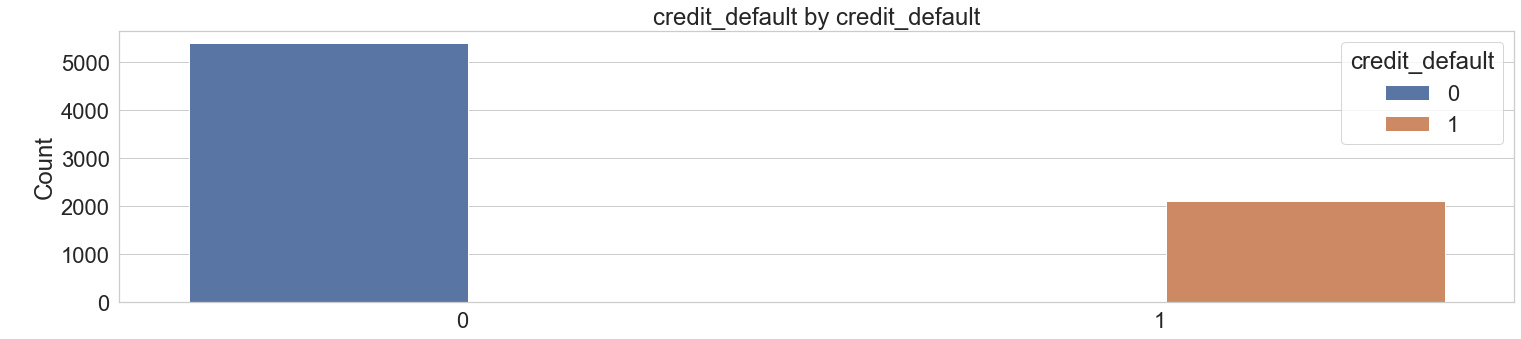

In [ ]:
get_countplot(x=TARGET_NAME)

Очевидна несбалансированность целевой переменной - это надо учитывать при обучение модели.

**Анализ переменных**

In [ ]:
# временно добавим столбец id для расчётов
df_train['id'] = np.arange(0, df_train.shape[0])

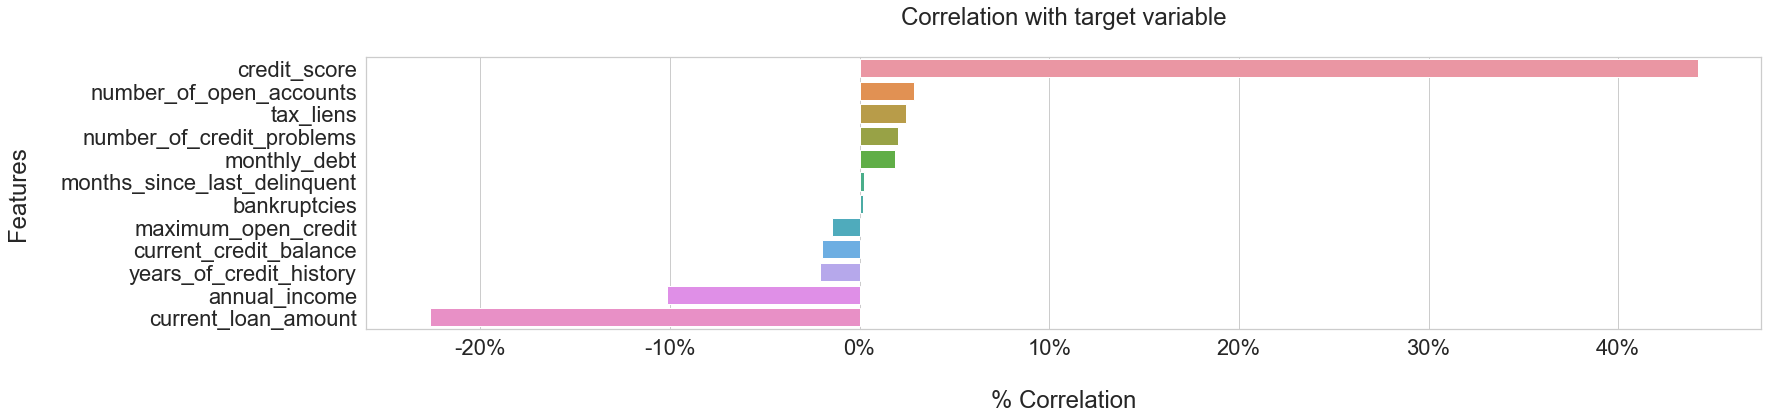

In [ ]:
corr_with_target = course_project_train.corr().iloc[:-1, -1].sort_values(ascending=False)

ax=sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

ax.set_title('Correlation with target variable\n')
ax.set_xlabel('\n% Correlation')
ax.set_xticklabels([f'{x:.0%}' for x in ax.get_xticks()])
ax.set_ylabel('Features\n');

In [ ]:
df_train.columns

Index(['home_ownership', 'annual_income', 'years_in_current_job', 'tax_liens',
       'number_of_open_accounts', 'years_of_credit_history',
       'maximum_open_credit', 'number_of_credit_problems',
       'months_since_last_delinquent', 'bankruptcies', 'purpose', 'term',
       'current_loan_amount', 'current_credit_balance', 'monthly_debt',
       'credit_score', 'credit_default', 'id'],
      dtype='object')

In [ ]:
#Home Ownership
df_train.home_ownership.value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: home_ownership, dtype: int64

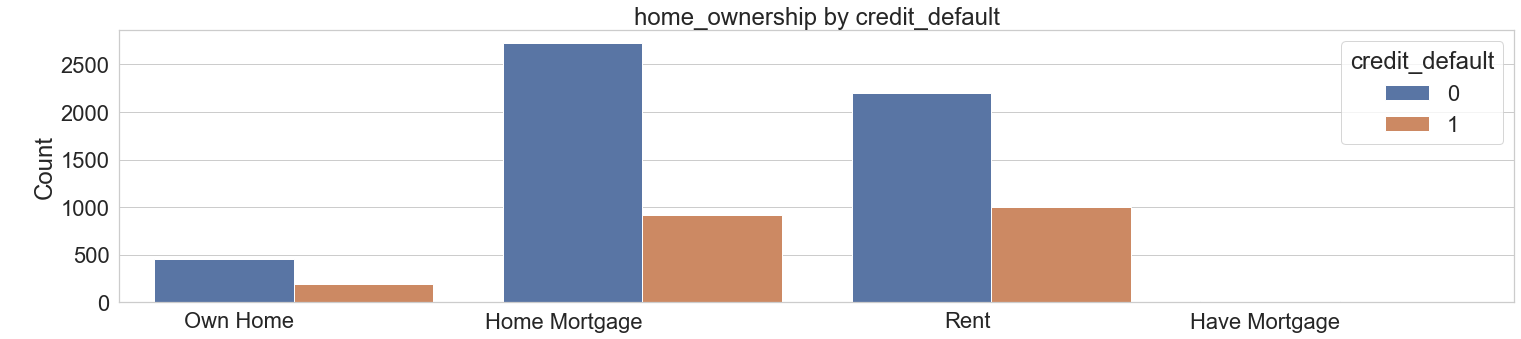

In [ ]:
get_countplot('home_ownership')

In [ ]:
get_prob_target('home_ownership')

,home_ownership,credit_default
0,Have Mortgage,0.166667
1,Home Mortgage,0.251856
2,Own Home,0.296754
3,Rent,0.313046


*Видно, что распределение в категории home_mortage и rent имеют схожие доли в разрезе целевой переменной.  
Возможно, стоит их объединить в одну категорию.*

**Гипотеза**  
Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы.  

Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы.

Критерий: Хи-квадрат Пирсона  
Уровень значимости α : 0.05  
Критическая область: двухсторонняя  

Для проверки нулевой гипотезы необходимо подать наблюдаемые частоты категорий Home Mortgage и Rent признака home_ownership в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то нулевую гипотезу (о согласованности частот) можно не отбрасывать.

In [ ]:
home_and_target_s = df_train.loc[df_train.home_ownership.isin(['Home Mortgage', 'Rent']), ['id','home_ownership', TARGET_NAME]].sample(2000)

In [ ]:
table = home_and_target_s.pivot_table(values='id', index='home_ownership', columns=TARGET_NAME, aggfunc='count')
table

credit_default,0,1
home_ownership,,
Home Mortgage,812,261
Rent,673,254


In [ ]:
# Проверим гипотезу, используя критерий Хи-квадрат Пирсона
chi2, p, dof, expected = scipy.stats.chi2_contingency(table, correction=False)
p

0.11670186917832744

Р-value говорит о том, что нужно отвергнуть нулевую гипотезу. Показатели по разному влияют на целевую

Попробуем оценить значение Home Mortgage & Own Home для признака home_ownership

In [ ]:
home_and_target_s = df_train.loc[df_train.home_ownership.isin(['Home Mortgage', 'Own Home']), ['id','home_ownership', TARGET_NAME]].sample(2000)

In [ ]:
table = home_and_target_s.pivot_table(values='id', index='home_ownership', columns=TARGET_NAME, aggfunc='count')
table

credit_default,0,1
home_ownership,,
Home Mortgage,1258,415
Own Home,234,93


In [ ]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(table, correction=False)
p

0.16729171108990631

In [ ]:
# Отвергаем нулевую гипотезу и объединяем признаки:
df_train.loc[df_train.home_ownership.isin(['Home Mortgage','Own Home']),'home_ownership'] = 'Home'
df_test.loc[df_test.home_ownership.isin(['Home Mortgage','Own Home']),'home_ownership'] = 'Home'

In [ ]:
get_prob_target('home_ownership')

,home_ownership,credit_default
0,Have Mortgage,0.166667
1,Home,0.258637
2,Rent,0.313046


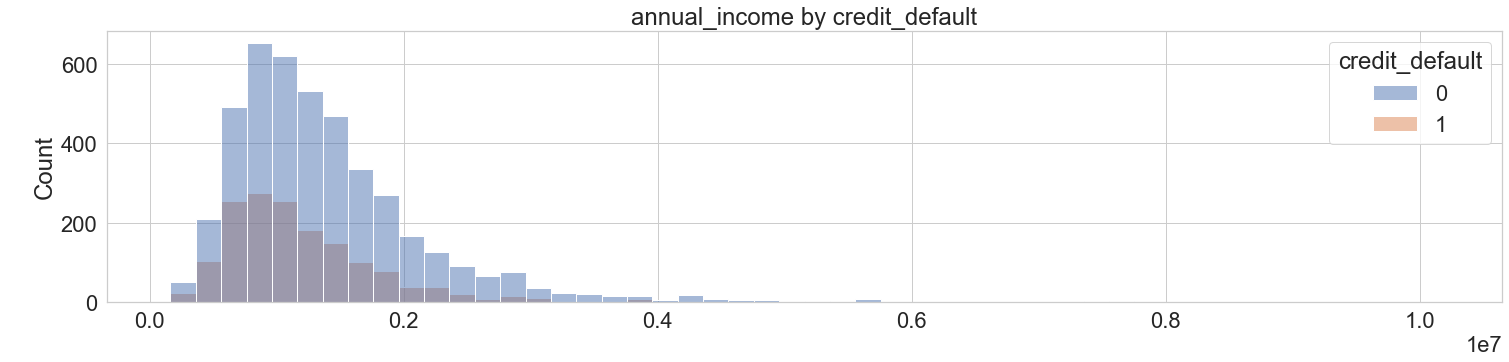

In [ ]:
# Annual Income

get_histplot('annual_income',bins=50)

In [ ]:
df_train.annual_income.isna().sum()

1557

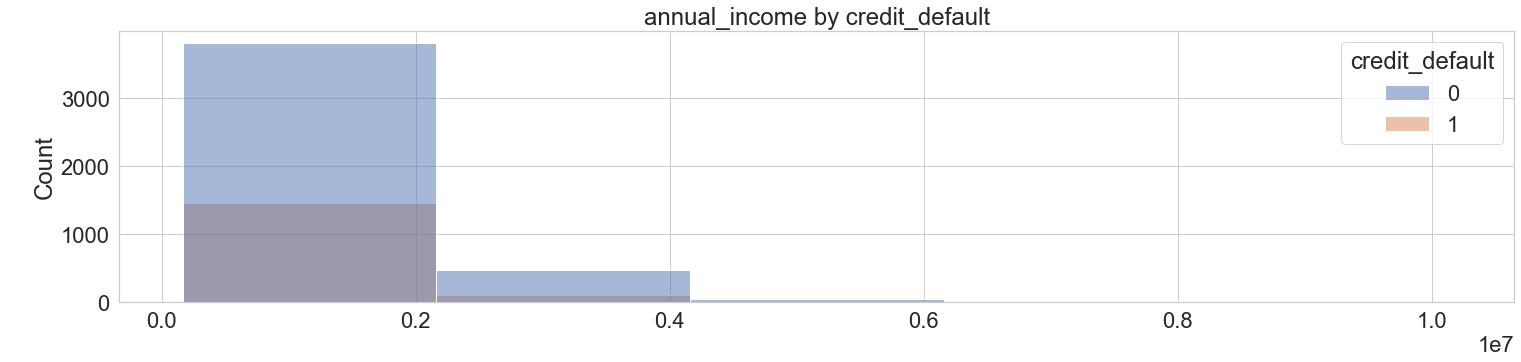

In [ ]:
get_histplot(df=df_train[~df_train.annual_income.isna()],x='annual_income',bins=5)

С учётом неравномерного распределения показателя, имеет смысл заполнить пропущенные значение медианой или сгруппированной величиной.  

Проверим с каким признаком коррелирует больше всего.

In [ ]:
df_train.corr()['annual_income'].sort_values(ascending=False)

annual_income                   1.000000
monthly_debt                    0.584819
current_credit_balance          0.386481
number_of_open_accounts         0.188524
years_of_credit_history         0.186531
tax_liens                       0.066245
maximum_open_credit             0.062218
current_loan_amount             0.032082
id                              0.011426
number_of_credit_problems      -0.015407
credit_score                   -0.037832
bankruptcies                   -0.066877
credit_default                 -0.101375
months_since_last_delinquent   -0.101787
Name: annual_income, dtype: float64

<AxesSubplot:xlabel='years_in_current_job', ylabel='annual_income'>

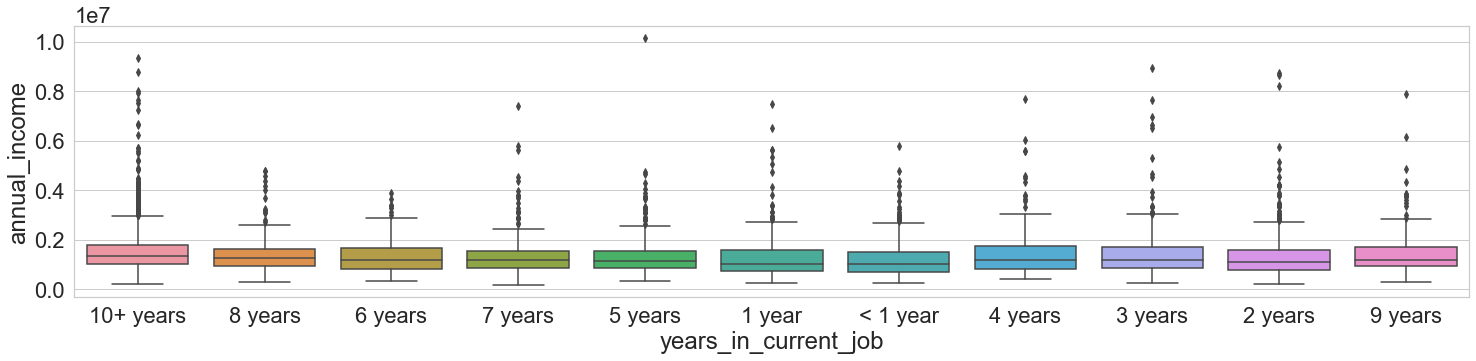

In [ ]:
sns.boxplot(data=df_train, x='years_in_current_job',y='annual_income')

<AxesSubplot:xlabel='term', ylabel='annual_income'>

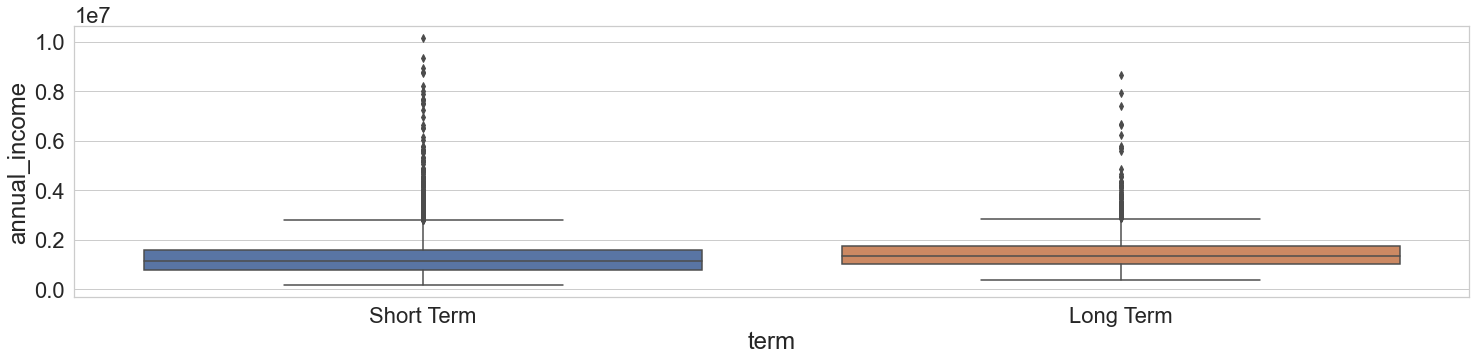

In [ ]:
sns.boxplot(data=df_train, x='term', y='annual_income')

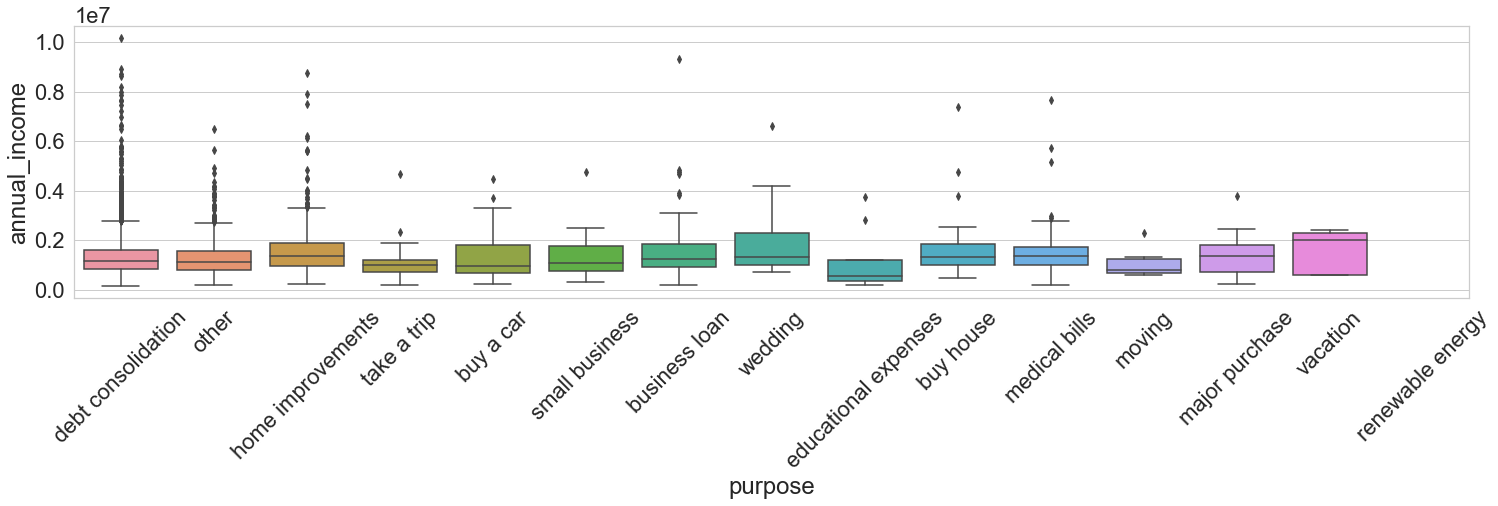

In [ ]:
ax=sns.boxplot(data=df_train, x='purpose', y='annual_income')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45);

Видно, что основные различия по всем категориальным группам получаются за счёт выбросов. 

И в итоге заполнять пропуски можно как константой, так и медианой.

Принимаем вариант с константой.

In [ ]:
df_train.annual_income.fillna(-9999,inplace=True)

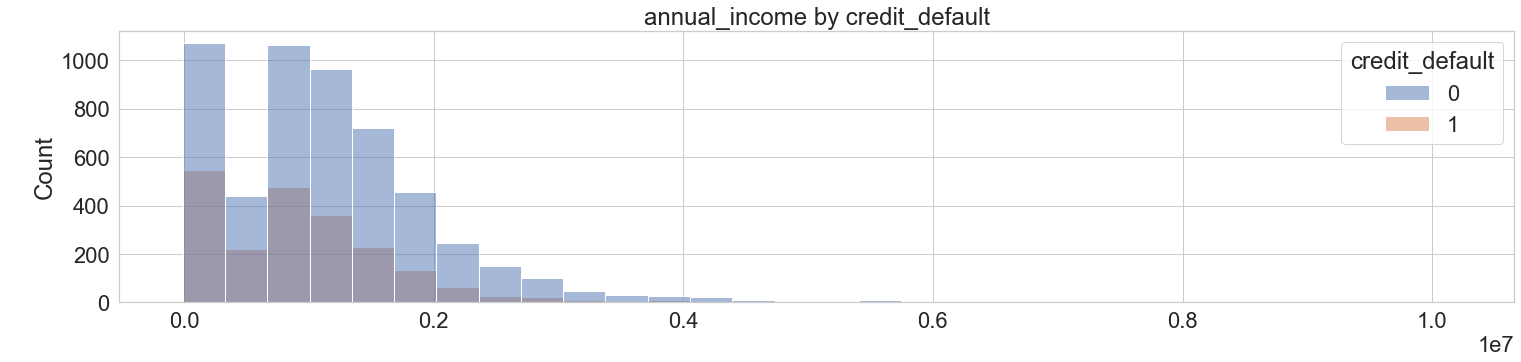

In [ ]:
# Посмотрим на annual_income

get_histplot('annual_income')

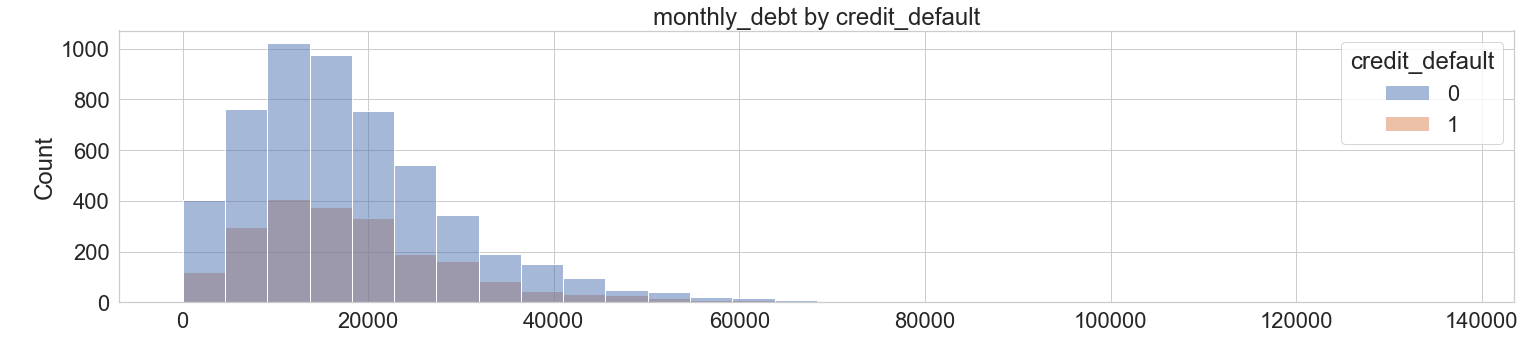

In [ ]:
# Посмотрим на monthly_debt

get_histplot('monthly_debt')

In [ ]:
df_train.monthly_debt.describe()

count      7500.000000
mean      18314.454133
std       11926.764673
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: monthly_debt, dtype: float64

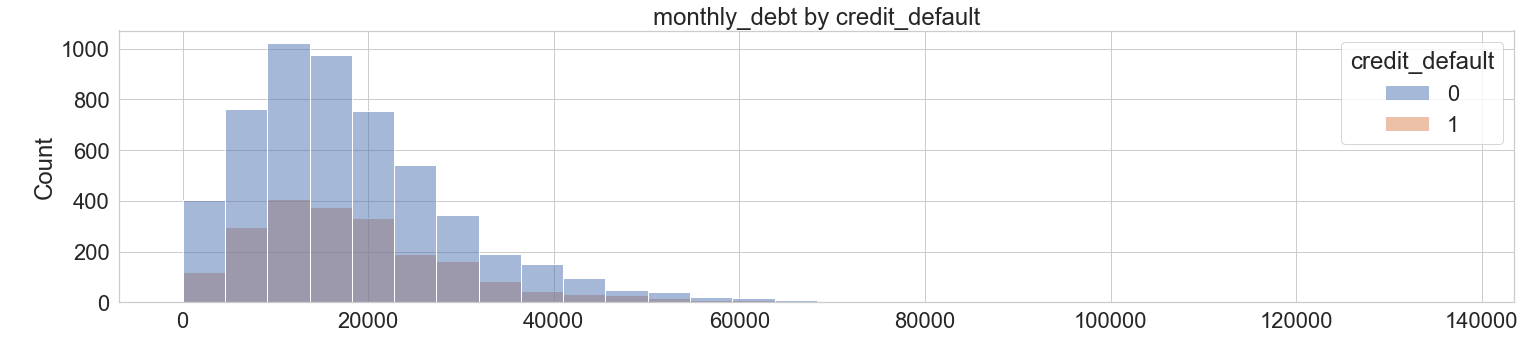

In [ ]:
# Проверим в разрезе целевой переменной

get_histplot('monthly_debt',bins=30)

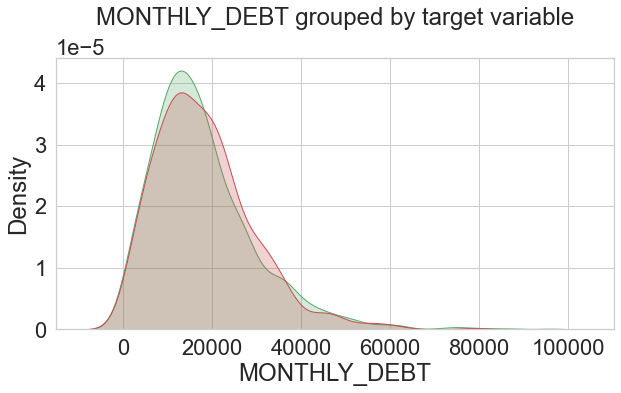

In [ ]:
# Визуально заметной разницы нет.  
# Проверим

monthly_debt_with_target_s = df_train[['monthly_debt', TARGET_NAME]].sample(2000)
monthky_debt_s = monthly_debt_with_target_s['monthly_debt']
target_0 = monthky_debt_s[monthly_debt_with_target_s[TARGET_NAME] == 0]
target_1 = monthky_debt_s[monthly_debt_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(target_0, shade=True, label='No default', color='g')
sns.kdeplot(target_1, shade=True, label='Default', color='r')

plt.xlabel('MONTHLY_DEBT')
plt.title('MONTHLY_DEBT grouped by target variable\n')
plt.show()

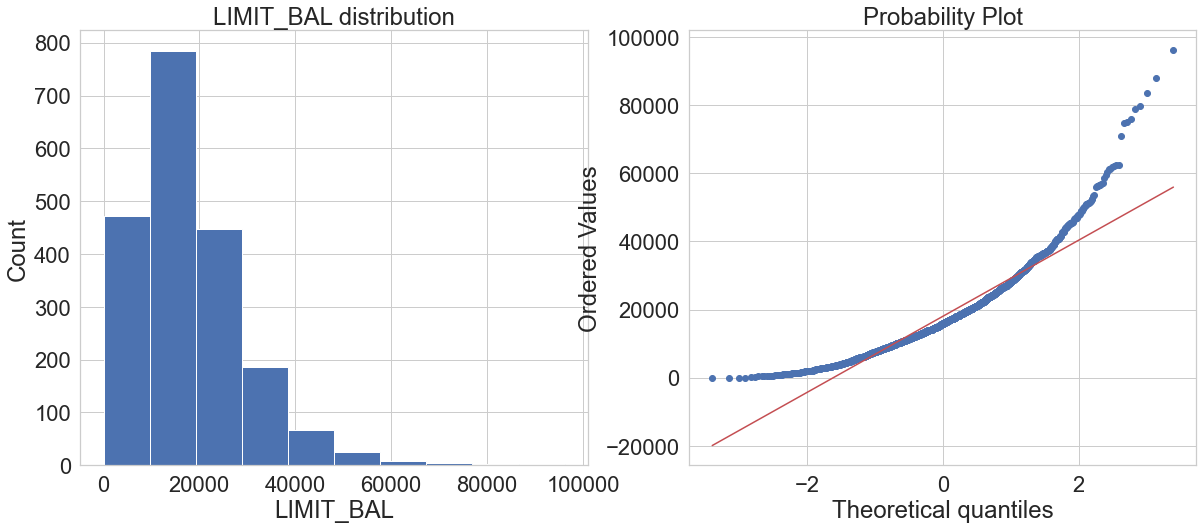

In [ ]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('LIMIT_BAL')
ax1.set_ylabel('Count')
ax1.set_title('LIMIT_BAL distribution')
monthky_debt_s.hist()

plt.subplot(122)
scipy.stats.probplot(monthky_debt_s, dist='norm', plot=plt)

plt.show()

In [ ]:
scipy.stats.shapiro(monthky_debt_s)

ShapiroResult(statistic=0.904931902885437, pvalue=1.3991706301391179e-33)

In [ ]:
# Из-за ненормальности распределения используем критерий Минна-Уитни

scipy.stats.mannwhitneyu(target_0, target_1)

MannwhitneyuResult(statistic=394581.0, pvalue=0.2819193536911121)

In [ ]:
scipy.stats.mannwhitneyu(target_0, target_1)

MannwhitneyuResult(statistic=394581.0, pvalue=0.2819193536911121)

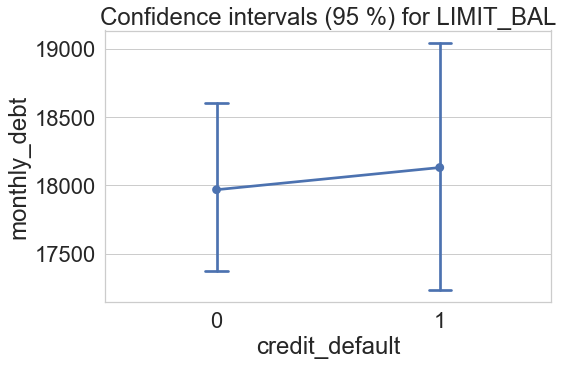

In [ ]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='monthly_debt', data=monthly_debt_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for LIMIT_BAL')
plt.show()

Считаем, что нет оснований отвергать нулевую гипотезу о равенстве средних.

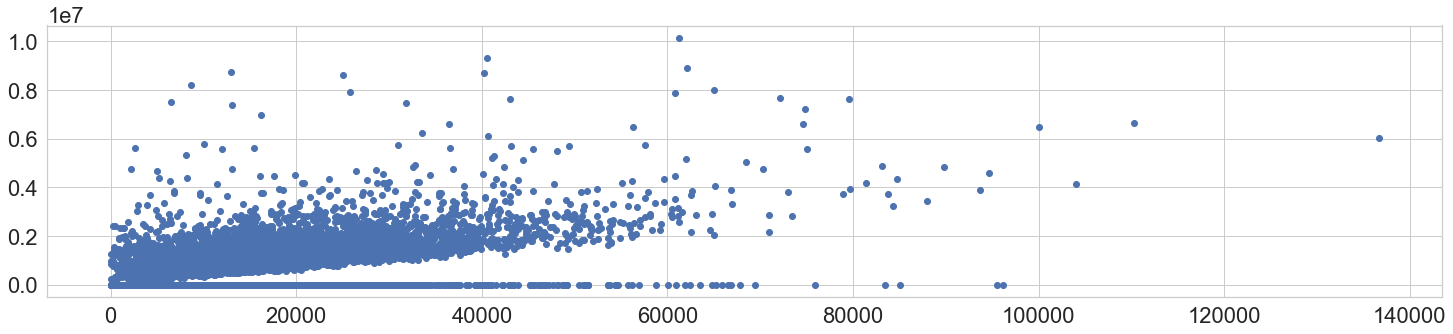

In [ ]:
plt.scatter(x='monthly_debt', y='annual_income', data=df_train)

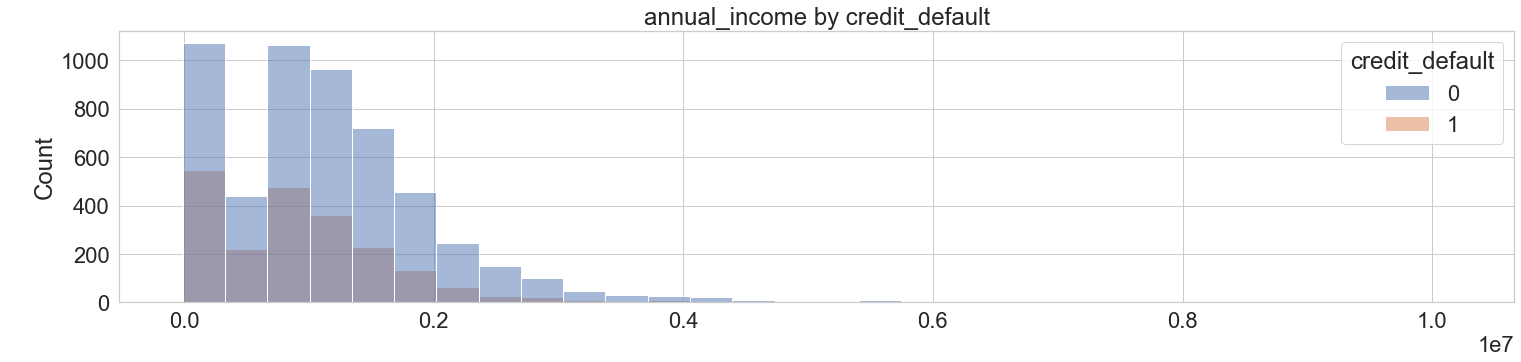

In [ ]:
# Теперь рассмотрим в разрезе целевой переменной

get_histplot('annual_income')

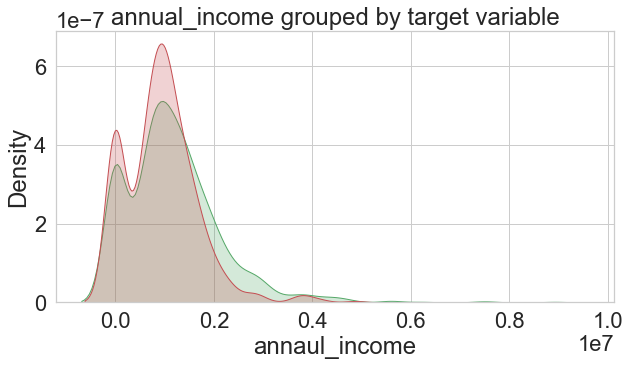

In [ ]:
annual_with_target_s = df_train[['annual_income', TARGET_NAME]].sample(2000)
annual_s = annual_with_target_s['annual_income']
annual_target_0 = annual_s[annual_with_target_s[TARGET_NAME] == 0]
annual_target_1 = annual_s[annual_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_target_0, shade=True, label='No default', color='g')
sns.kdeplot(annual_target_1, shade=True, label='Default', color='r')

plt.xlabel('annaul_income')
plt.title('annual_income grouped by target variable')
plt.show()


In [ ]:
scipy.stats.shapiro(annual_s)

ShapiroResult(statistic=0.8771372437477112, pvalue=4.218149176745809e-37)

In [ ]:
scipy.stats.mannwhitneyu(annual_target_0, annual_target_1)

MannwhitneyuResult(statistic=466673.5, pvalue=1.4659057230495797e-06)

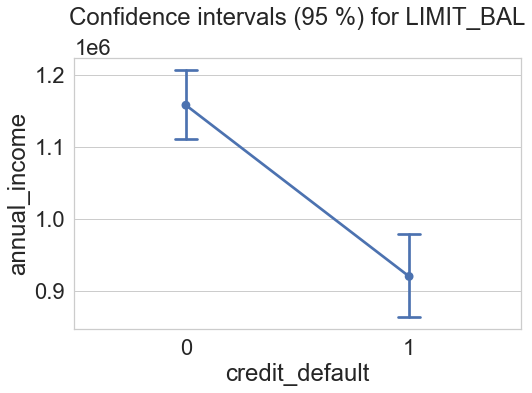

In [ ]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='annual_income', data=annual_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for LIMIT_BAL\n')
plt.show()

Видим, что средние значения по целевой переменной значимо отличаются.  
Значит, этот признак может быть полезен для определения целевой переменной.

Произведем log-трансформацию признака

In [ ]:
df_train['annual_income_log'] = df_train.annual_income.apply(np.log)
df_test['annual_income_log'] = df_test.annual_income.apply(np.log)

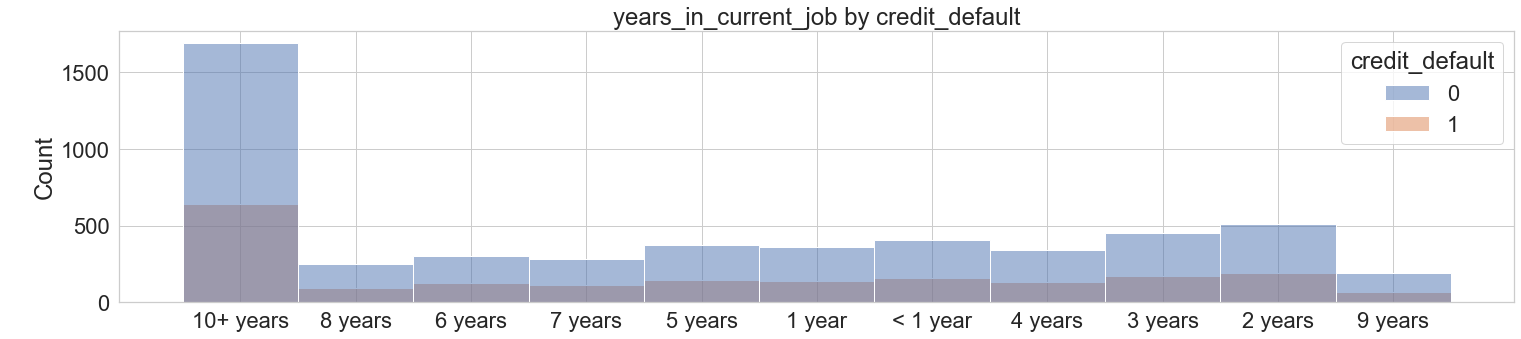

In [ ]:
# Посмотрим на years_in_current_job (количество лет на текущем месте работы)

get_histplot('years_in_current_job')

In [ ]:
# Оценим пропуски в разрезе таргета

df_train.loc[df_train.years_in_current_job.isna(),['years_in_current_job',TARGET_NAME]].agg({TARGET_NAME:'mean'})

credit_default    0.369272
dtype: float64

Вероятность попадания в таргет выше среднего, можно оставить константой.

In [ ]:
# Произведем замену на моду

df_train.years_in_current_job.mode()[0]

'10+ years'

In [ ]:
df_train.years_in_current_job.fillna(df_train.years_in_current_job.mode()[0], inplace=True)
df_test.years_in_current_job.fillna(df_test.years_in_current_job.mode()[0], inplace=True)

<AxesSubplot:xlabel='years_in_current_job', ylabel='Count'>

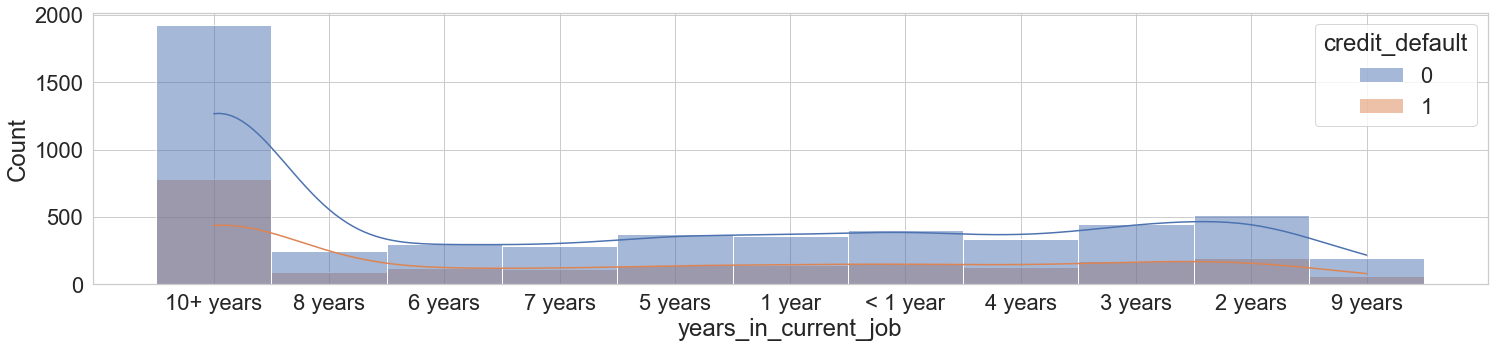

In [ ]:
sns.histplot(x='years_in_current_job', hue=TARGET_NAME,kde=True, alpha=0.5, data=df_train)

<AxesSubplot:xlabel='years_in_current_job', ylabel='count'>

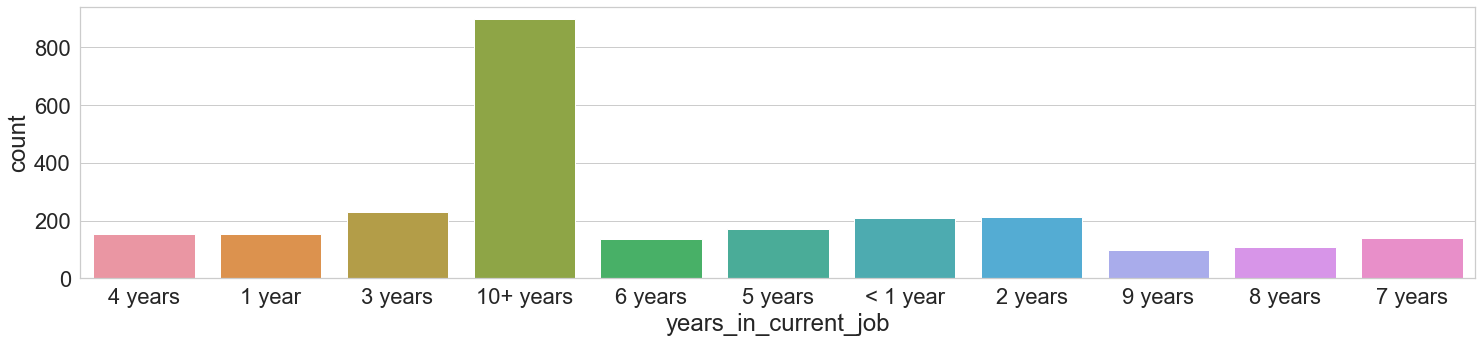

In [ ]:
sns.countplot(data=df_test, x='years_in_current_job')

In [ ]:
# Посмотрим на years_of_credit_history (количество лет кредитной истории)

df_train.years_of_credit_history.value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
44.0      1
39.8      1
40.0      1
39.9      1
48.3      1
Name: years_of_credit_history, Length: 408, dtype: int64

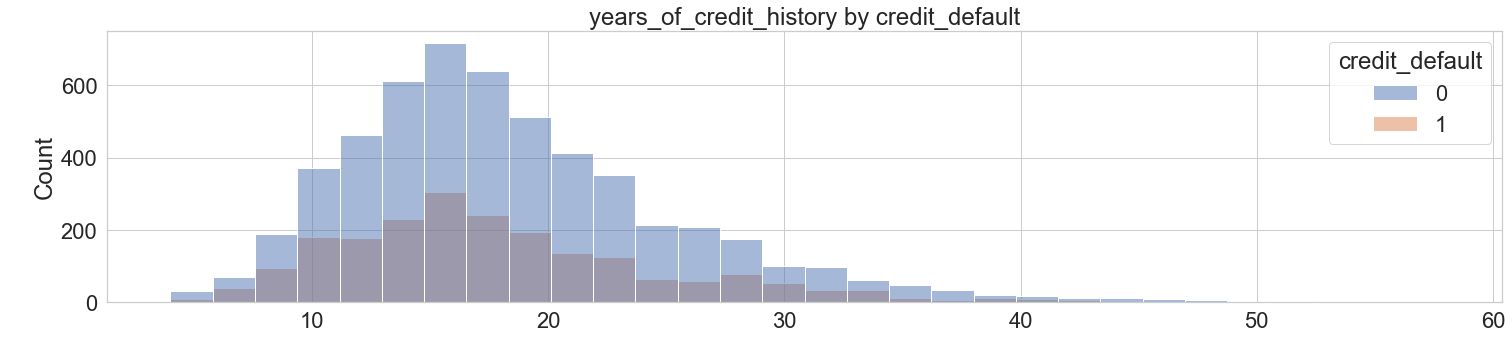

In [ ]:
get_histplot('years_of_credit_history', bins=30)

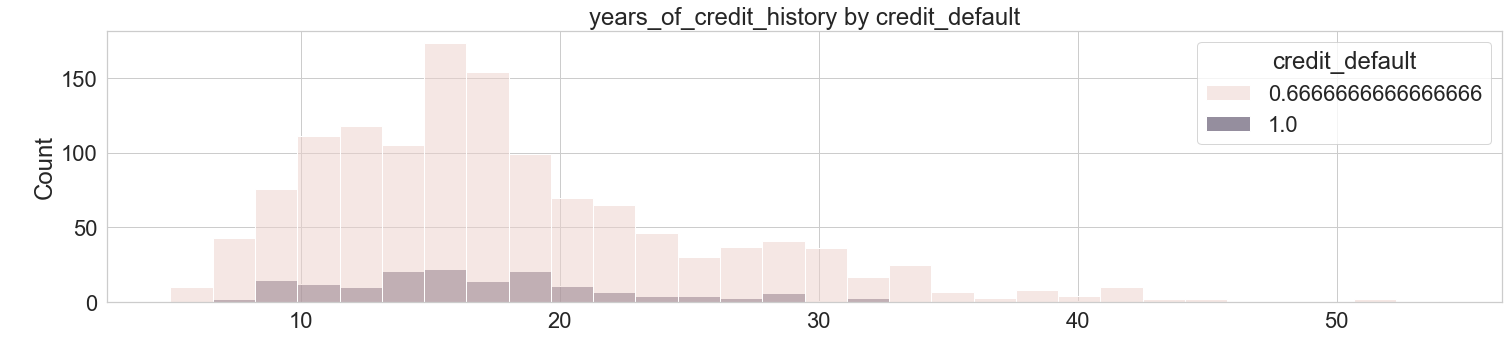

In [ ]:
# строим график распределения высоковероятного таргета (выше 0,5) в связи c длительностью кредитной истории

get_histplot(df=df_train[['years_of_credit_history',TARGET_NAME]]\
  .sort_values(by='years_of_credit_history')\
  .rolling(3, min_periods=1)\
  .mean()\
  .query('credit_default > 0.5'), x='years_of_credit_history')

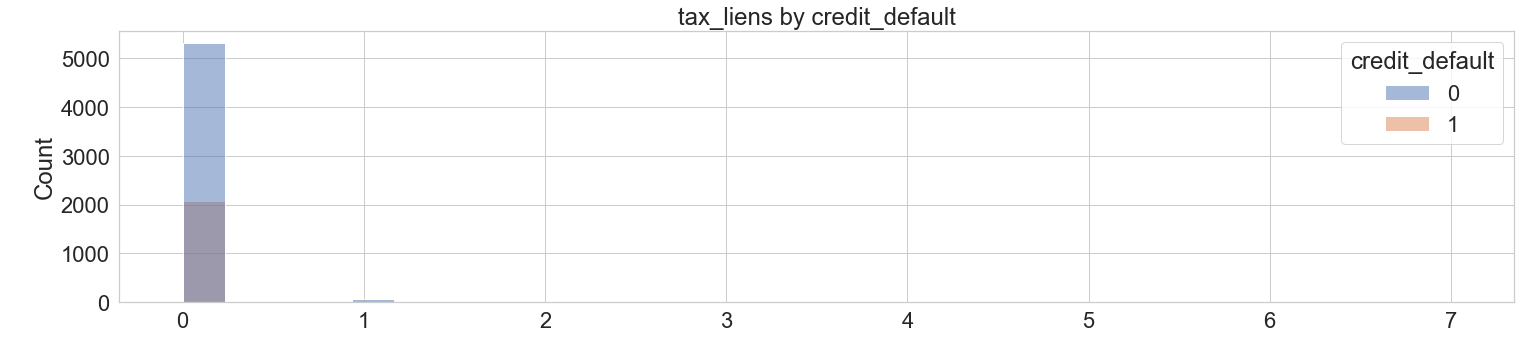

In [ ]:
# Посмотрим на  tax_liens (налоговые обременения)

get_histplot('tax_liens')

In [ ]:
df_train.tax_liens.value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: tax_liens, dtype: int64

In [ ]:
df_train.tax_liens = df_train.tax_liens.apply(lambda x: int(x))
df_test.tax_liens = df_test.tax_liens.apply(lambda x: int(x))

In [ ]:
get_prob_target('tax_liens')

,tax_liens,credit_default
0,0,0.280342
1,1,0.289157
2,2,0.500000
3,3,0.500000
4,4,0.500000
5,5,0.500000
6,6,0.000000
7,7,0.000000


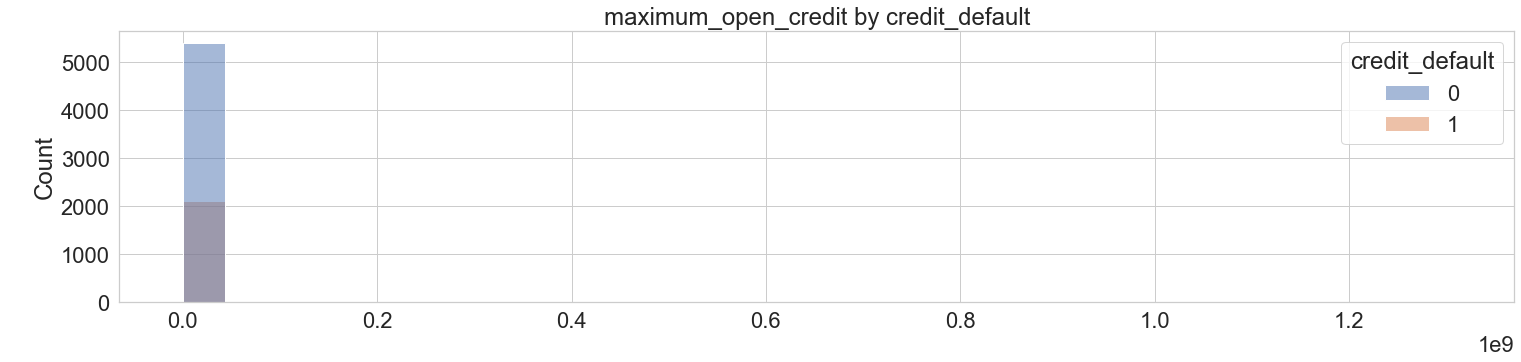

In [ ]:
# Посмотрим на maximum_open_credit (наибольший открытый кредит)

get_histplot('maximum_open_credit')

In [ ]:
df_train.maximum_open_credit.describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: maximum_open_credit, dtype: float64

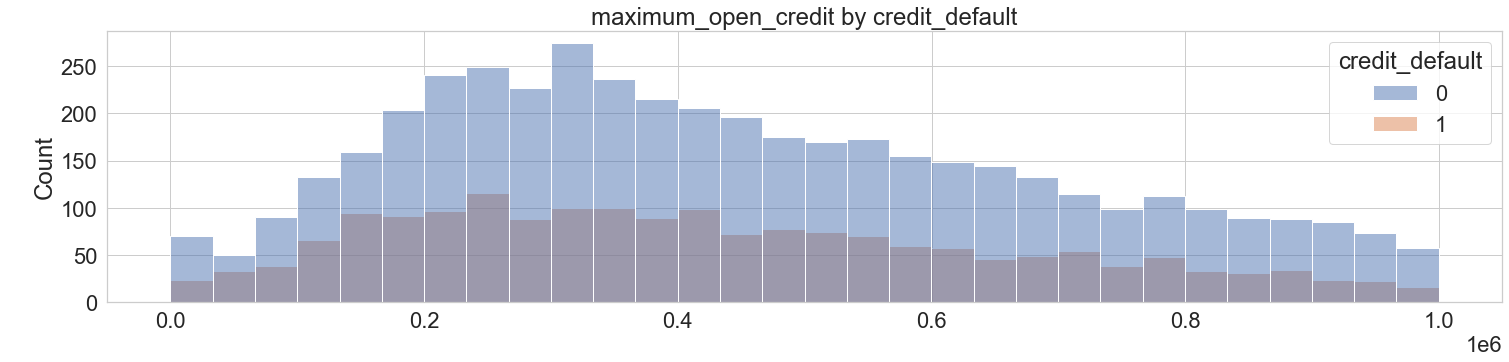

In [ ]:
get_histplot(df=df_train[df_train.maximum_open_credit < 1000000],x='maximum_open_credit')

Видим в данных выбросы, сами по себе большие суммы кредита не говорят об аномалиии в данных.

In [ ]:
# изменим нулевые значения для логаривмирования

df_train.loc[df_train.maximum_open_credit == 0, 'maximum_open_credit'] = 0.000001
df_test.loc[df_test.maximum_open_credit == 0, 'maximum_open_credit'] = 0.000001

In [ ]:
df_train['maximum_open_credit_log'] = df_train.maximum_open_credit.apply(np.log)
df_test['maximum_open_credit_log'] = df_test.maximum_open_credit.apply(np.log)

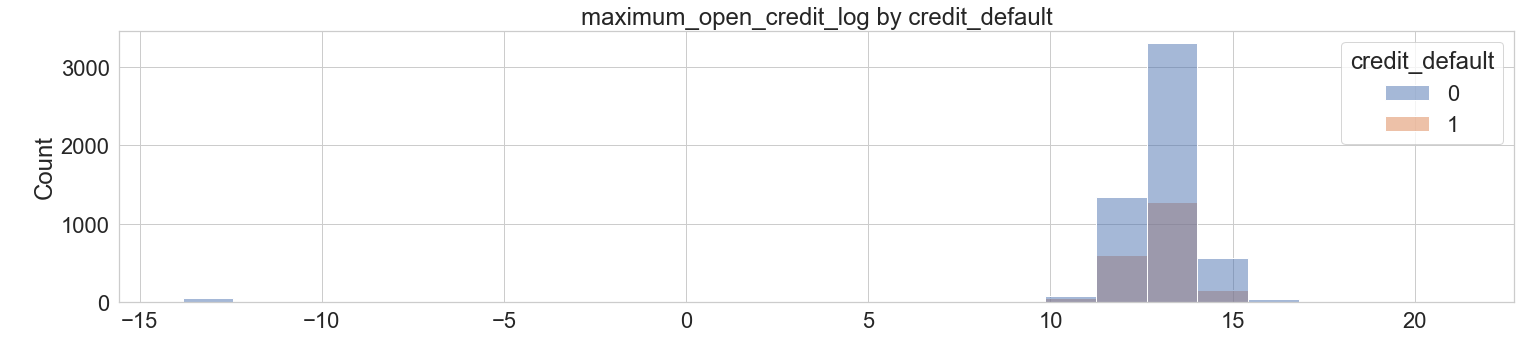

In [ ]:
get_histplot('maximum_open_credit_log', bins=25)

In [ ]:
# Посмотрим на  number_of_credit_problems (количество проблем с кредитом)

df_train.number_of_credit_problems.value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: number_of_credit_problems, dtype: int64

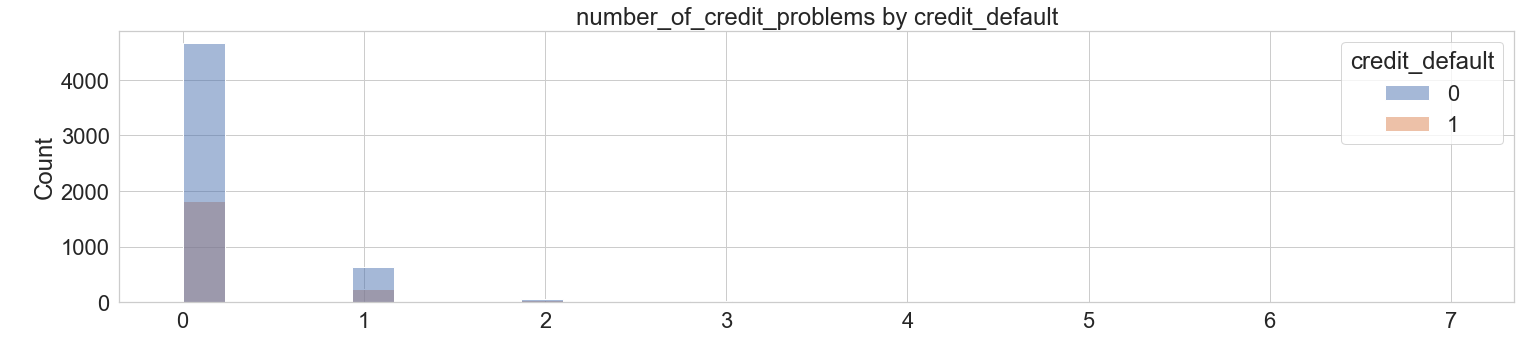

In [ ]:
get_histplot('number_of_credit_problems')

In [ ]:
# переведём переменную в int для дальнейшего отнесения к категорияльным 

df_train.number_of_credit_problems.apply(int)
df_test.number_of_credit_problems.apply(int)

0       0
1       0
2       0
3       0
4       0
       ..
2495    1
2496    0
2497    0
2498    0
2499    1
Name: number_of_credit_problems, Length: 2500, dtype: int64

In [ ]:
get_prob_target('number_of_credit_problems')

,number_of_credit_problems,credit_default
0,0.0,0.280569
1,1.0,0.273243
2,2.0,0.354839
3,3.0,0.400000
4,4.0,0.666667
5,5.0,0.571429
6,6.0,0.000000
7,7.0,0.000000


Видим схожие попарно схожие значения.  
Проверим группы.

In [ ]:
problem_and_target_s = df_train.loc[df_train.number_of_credit_problems.isin([0,1]), ['id','number_of_credit_problems', TARGET_NAME]].sample(1000)
problem_and_target_s

,id,number_of_credit_problems,credit_default
7458,7458,0.0,1
3882,3882,0.0,0
789,789,1.0,0
6134,6134,0.0,1
7326,7326,0.0,0
...,...,...,...
2255,2255,0.0,0
4092,4092,0.0,0
5986,5986,0.0,1
5607,5607,0.0,0


In [ ]:
table = problem_and_target_s.pivot_table(values='id', index='number_of_credit_problems', columns=TARGET_NAME, aggfunc='count')
table

credit_default,0,1
number_of_credit_problems,,
0.0,664,226
1.0,81,29


In [ ]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(table, correction=False)
p

0.8256495541374124

На разных размерах тест даёт слишком противоречивые показатели.  
В тестовом режиме объединим схожие показатели.

In [ ]:
bins=[0,
     2,
     4,
     6,
     8]

In [ ]:
labels=[0,
       1,
       2,
       4]

In [ ]:
df_train.number_of_credit_problems = pd.cut(df_train.number_of_credit_problems, bins=bins,labels=labels, right=False)
df_test.number_of_credit_problems = pd.cut(df_test.number_of_credit_problems, bins=bins,labels=labels, right=False)

In [ ]:
get_prob_target('number_of_credit_problems')

,number_of_credit_problems,credit_default
0,0,0.279690
1,1,0.367188
2,2,0.625000
3,4,0.000000


In [ ]:
df_train.number_of_credit_problems.isna().sum()

0

In [ ]:
df_test.number_of_credit_problems.isna().sum()

1

In [ ]:
df_test.number_of_credit_problems.fillna(df_test.number_of_credit_problems.mode()[0], inplace=True)

In [ ]:
# Посмотрим на  months_since_last_delinquent (количество месяцев с последней просрочки платежа)

df_train.months_since_last_delinquent.isna().sum()

4081

In [ ]:
df_train.months_since_last_delinquent

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
7495     NaN
7496    43.0
7497     NaN
7498     NaN
7499     NaN
Name: months_since_last_delinquent, Length: 7500, dtype: float64

Более половины признака пропущенны.  
Скорее всего имеет смысл просто удалить признак (количество месяцев с последней просрочки платежа).  
Однако, проверим отдельно в разрезе целевой переменной.

In [ ]:
df_train.months_since_last_delinquent.loc[~df_train.months_since_last_delinquent.isna()]

6       73.0
7       18.0
9        6.0
18      40.0
20      44.0
        ... 
7489    35.0
7490    69.0
7491     6.0
7493    58.0
7496    43.0
Name: months_since_last_delinquent, Length: 3419, dtype: float64

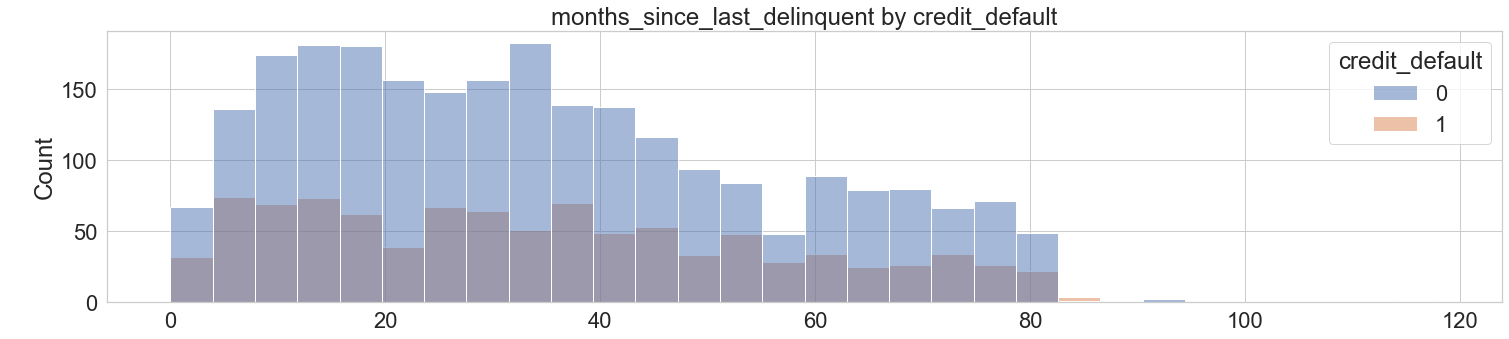

In [ ]:
get_histplot(df=df_train.loc[~df_train.months_since_last_delinquent.isna()],x='months_since_last_delinquent')

<AxesSubplot:>

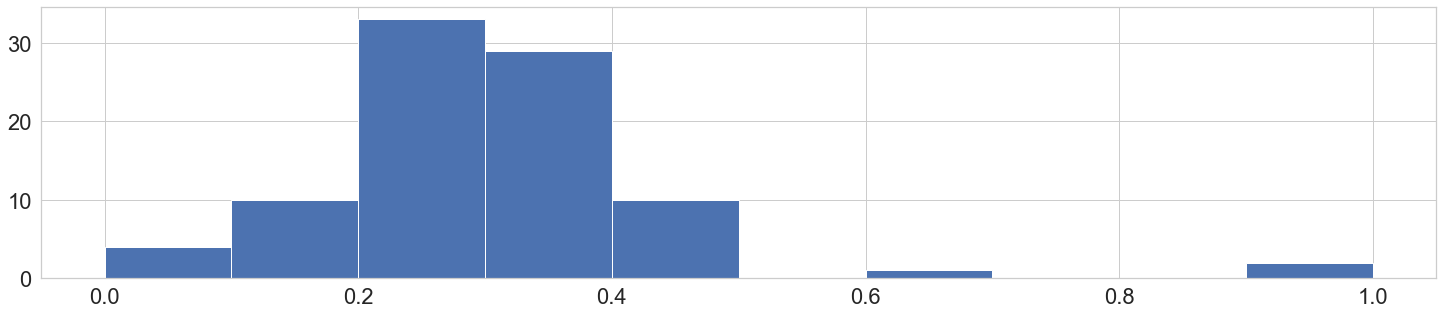

In [ ]:
get_prob_target(df=df_train.loc[~df_train.months_since_last_delinquent.isna()],x='months_since_last_delinquent')\
.sort_values(by='credit_default')\
.credit_default.hist()

Видно, что пропущенные не сильно отличаются от общего значения, поэтому оставим в таком виде.

In [ ]:
df_train.corr()['months_since_last_delinquent'].sort_values()

annual_income_log              -0.091122
annual_income                  -0.071845
monthly_debt                   -0.057702
number_of_open_accounts        -0.032740
current_credit_balance         -0.027198
years_of_credit_history        -0.015375
maximum_open_credit_log        -0.011717
credit_score                   -0.004395
maximum_open_credit            -0.003849
current_loan_amount             0.000459
credit_default                  0.002598
id                              0.007262
tax_liens                       0.052446
bankruptcies                    0.162710
months_since_last_delinquent    1.000000
Name: months_since_last_delinquent, dtype: float64

In [ ]:
df_train.months_since_last_delinquent.fillna(df_train.months_since_last_delinquent.median(), inplace=True)
df_test.months_since_last_delinquent.fillna(df_train.months_since_last_delinquent.median(), inplace=True)

In [ ]:
df_train.months_since_last_delinquent.isna().sum()

0

<AxesSubplot:xlabel='months_since_last_delinquent', ylabel='Count'>

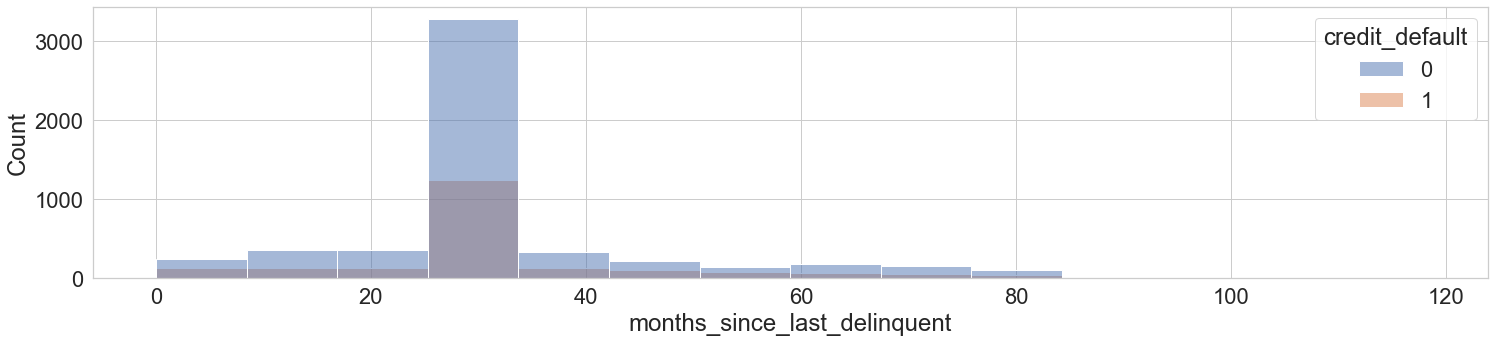

In [ ]:
sns.histplot(x='months_since_last_delinquent', hue=TARGET_NAME, data=df_train)

In [ ]:
# Посмотрим на  bankruptcies (банкротства)

df_train.bankruptcies.value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: bankruptcies, dtype: int64

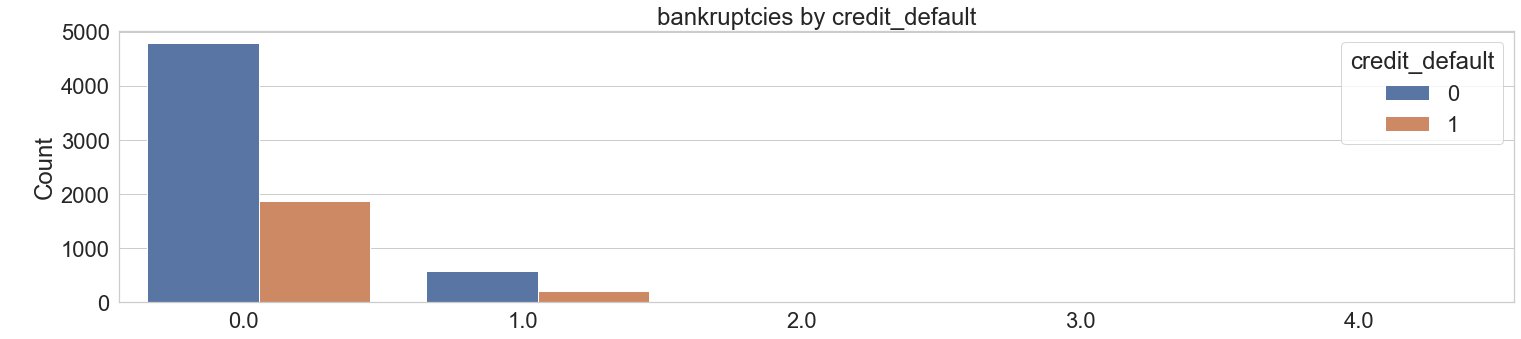

In [ ]:
get_countplot('bankruptcies')

In [ ]:
get_prob_target('bankruptcies')

,bankruptcies,credit_default
0,0.0,0.281982
1,1.0,0.276081
2,2.0,0.354839
3,3.0,0.285714
4,4.0,0.500000


In [ ]:
df_train.corr()['bankruptcies'].sort_values(ascending=False)

bankruptcies                    1.000000
months_since_last_delinquent    0.109507
years_of_credit_history         0.085699
tax_liens                       0.057360
id                              0.003183
credit_default                  0.001648
current_loan_amount            -0.005987
maximum_open_credit            -0.011650
number_of_open_accounts        -0.019130
maximum_open_credit_log        -0.026384
credit_score                   -0.027488
annual_income                  -0.045537
annual_income_log              -0.060712
monthly_debt                   -0.079579
current_credit_balance         -0.142849
Name: bankruptcies, dtype: float64

<AxesSubplot:xlabel='number_of_credit_problems', ylabel='Percent'>

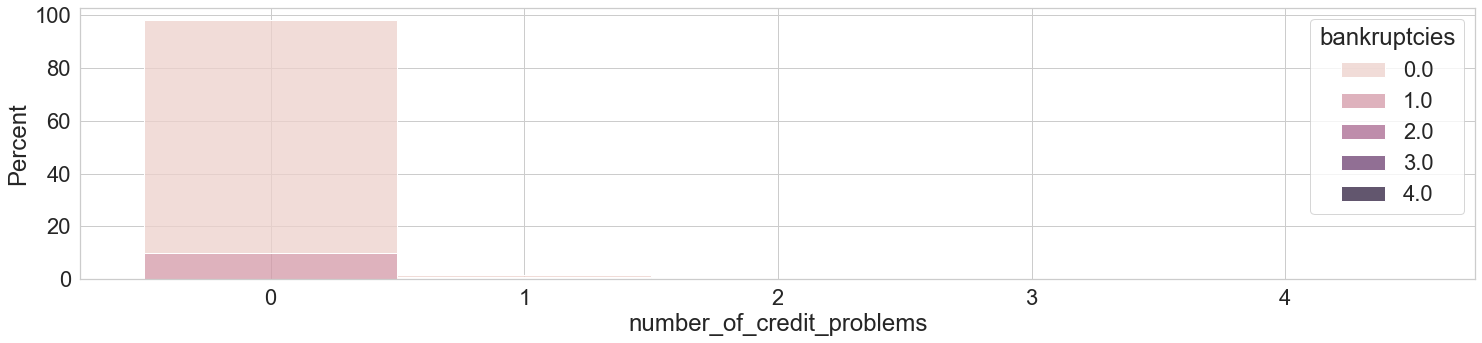

In [ ]:
sns.histplot(x='number_of_credit_problems', hue = 'bankruptcies', multiple='stack',stat='percent', data=df_train)

In [ ]:
df_train.bankruptcies.fillna(df_train.groupby('number_of_credit_problems')['bankruptcies'].transform('max'),inplace=True)
df_test.bankruptcies.fillna(df_train.groupby('number_of_credit_problems')['bankruptcies'].transform('max'),inplace=True)

In [ ]:
df_train.bankruptcies.isna().sum()

0

In [ ]:
df_train.number_of_credit_problems = df_train.number_of_credit_problems.apply(int)
df_test.number_of_credit_problems = df_test.number_of_credit_problems.apply(int)

In [ ]:
# Посмотрим на  purpose (цель кредита)

df_train.purpose.value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: purpose, dtype: int64

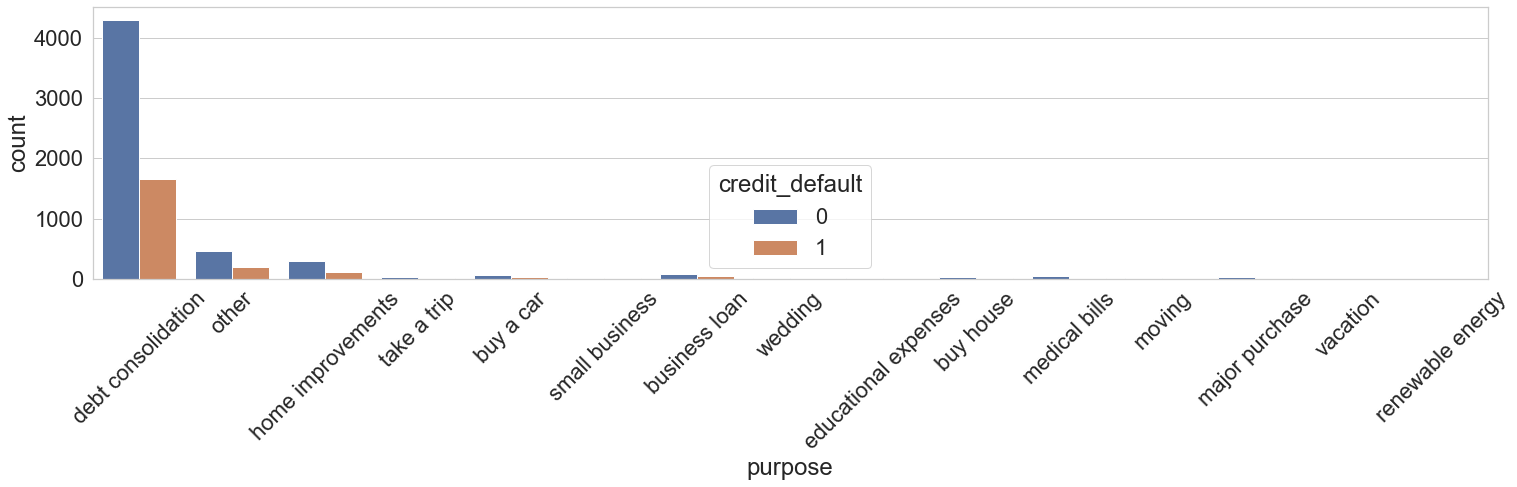

In [ ]:
ax=sns.countplot(x='purpose', hue=TARGET_NAME, data=df_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [ ]:
# Сгруппируем по таргету

get_prob_target('purpose').sort_values(by=TARGET_NAME)

,purpose,credit_default
4,educational expenses,0.100000
8,moving,0.181818
6,major purchase,0.225000
1,buy a car,0.250000
13,vacation,0.250000
5,home improvements,0.262136
2,buy house,0.264706
14,wedding,0.266667
12,take a trip,0.270270
3,debt consolidation,0.278264


In [ ]:
purpose_1 = ['major purchase',
             'vacation',
             'buy a car',
             'home improvements',
             'buy house',
             'wedding',
             'take a trip',
             'debt consolidation'
             ]
purpose_2 = ['other',
            'medical bills']
purpose_3 = ['business loan',
            'small business	']
purpose_4 = ['educational expenses',
            'moving']
def group_purpose(df):
    df.loc[df.purpose.isin(purpose_1),'purpose'] = 'various'
    df.loc[df.purpose.isin(purpose_2),'purpose'] = 'other+medical'
    df.loc[df.purpose.isin(purpose_3),'purpose'] = 'business'
    df.loc[df.purpose.isin(purpose_4),'purpose'] = 'education+moving'

In [ ]:
group_purpose(df_train)
group_purpose(df_test)

In [ ]:
get_prob_target('purpose')

,purpose,credit_default
0,business,0.426357
1,education+moving,0.142857
2,other+medical,0.297554
3,renewable energy,1.000000
4,small business,0.538462
5,various,0.276344


In [ ]:
purpose_target = df_train.loc[df_train.purpose.isin(['various', 'other+medical']),['id', 'purpose',TARGET_NAME]].sample(2000)
purpose_target

,id,purpose,credit_default
5215,5215,various,0
1412,1412,various,0
6446,6446,various,0
1525,1525,various,0
5566,5566,other+medical,0
...,...,...,...
5458,5458,various,0
5759,5759,other+medical,0
3903,3903,various,0
1217,1217,various,0


In [ ]:
pivot = purpose_target.pivot_table(values='id',columns=TARGET_NAME,index='purpose',aggfunc='count')
pivot

credit_default,0,1
purpose,,
other+medical,128,53
various,1337,482


In [ ]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(pivot, correction=False)
p

0.4197493506487938

In [ ]:
# Посмотрим на term (срок кредита)

In [ ]:
df_train.term.value_counts()

Short Term    5556
Long Term     1944
Name: term, dtype: int64

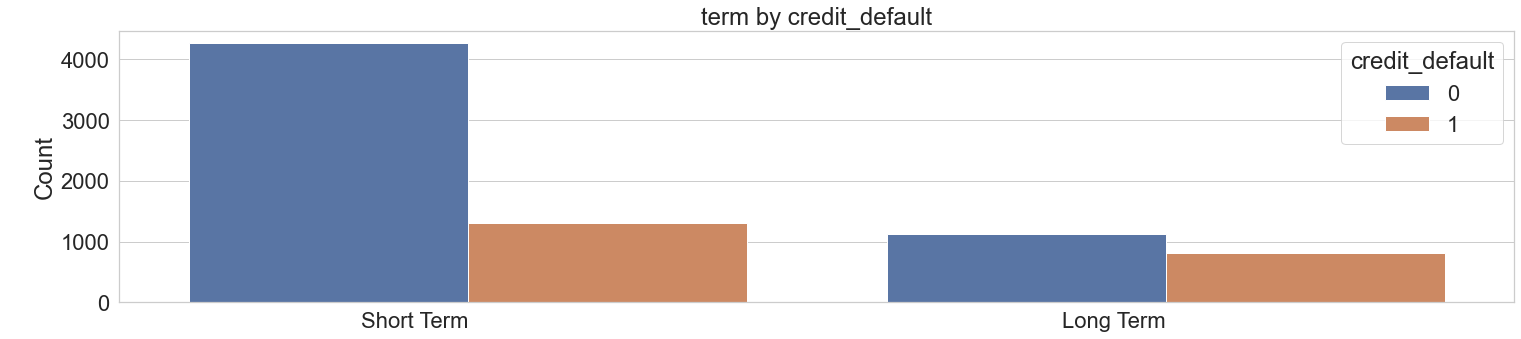

In [ ]:
get_countplot('term')

Видно, что в разделе LongTerm баланс классов изменен.

In [ ]:
term_and_target_s = df_train.loc[df_train['term'].isin(['Short Term', 'Long Term']), ['id', 'term', TARGET_NAME]].sample(2000)

In [ ]:
table2 = term_and_target_s.pivot_table(values='id', index='term', columns=TARGET_NAME, aggfunc='count')
table2

credit_default,0,1
term,,
Long Term,299,205
Short Term,1132,364


In [ ]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(table2, correction=False)
p

2.0184225757260074e-12

p-value получился значительно ниже порога в 0.05.
Отвергаем гипотезу о равенстве влияние переменной на таргет.

In [ ]:
# Посмотрим на  current_loan_amount (текущая сумма кредита)

In [ ]:
df_train.current_loan_amount.isna().sum()

0

In [ ]:
df_train.current_loan_amount.describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: current_loan_amount, dtype: float64

Значение max = 1e+08 значительно отличается от среднего и медианы, т.е. является выбросом.

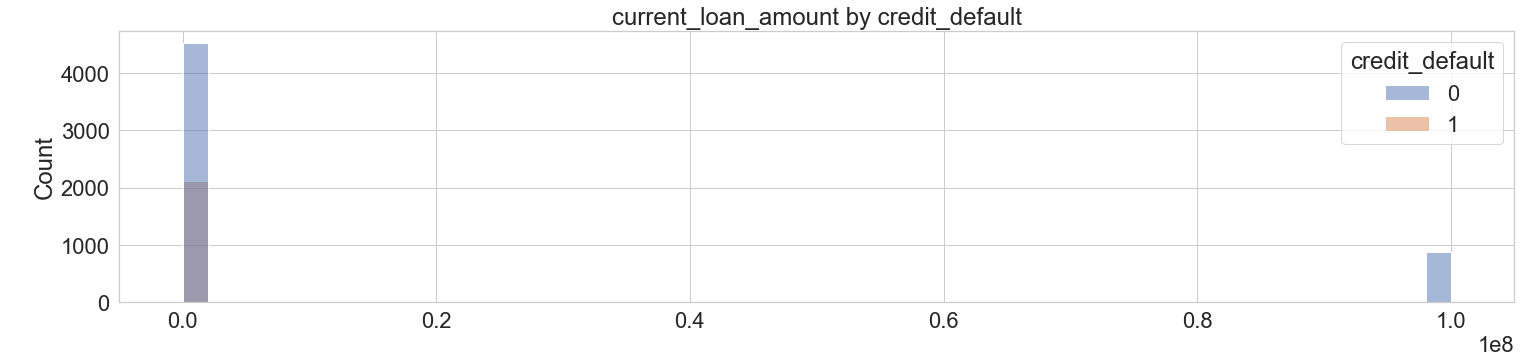

In [ ]:
get_histplot('current_loan_amount',bins=50)

Однако, в этих выбросах 0 показатель нашего таргета.  
Возможно, в этом есть какой-то смысл, поэтому оставим его без изменений.

In [ ]:
df_train.loc[df_train.current_loan_amount < 9000000, 'current_loan_amount'].max()

789030.0

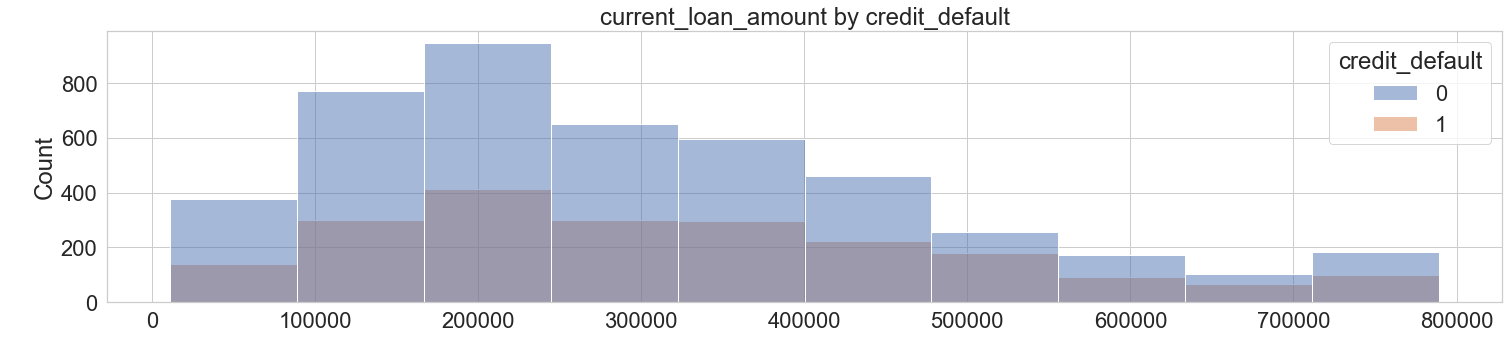

In [ ]:
# Попробуем разбить переменные на группы:
# < 9000000
get_histplot(df=df_train[df_train.current_loan_amount < 9000000], x='current_loan_amount', bins=10)

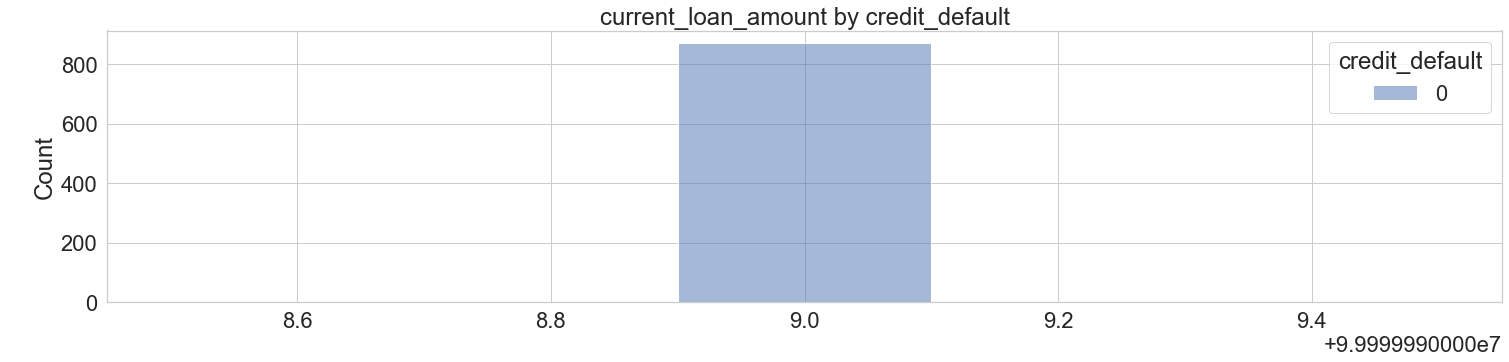

In [ ]:
# Попробуем разбить переменные на группы:
# > 9000000
get_histplot(df=df_train[df_train.current_loan_amount > 9000000], x='current_loan_amount', bins=5)

In [ ]:
# Видно, что эта группа однородна по целевому значения.  
# Имеет смысл оставить её без изменений.

df_train.loc[df_train.current_loan_amount > 99999900, 'current_loan_amount']

0       99999999.0
2       99999999.0
6       99999999.0
22      99999999.0
27      99999999.0
           ...    
7441    99999999.0
7445    99999999.0
7464    99999999.0
7475    99999999.0
7497    99999999.0
Name: current_loan_amount, Length: 870, dtype: float64

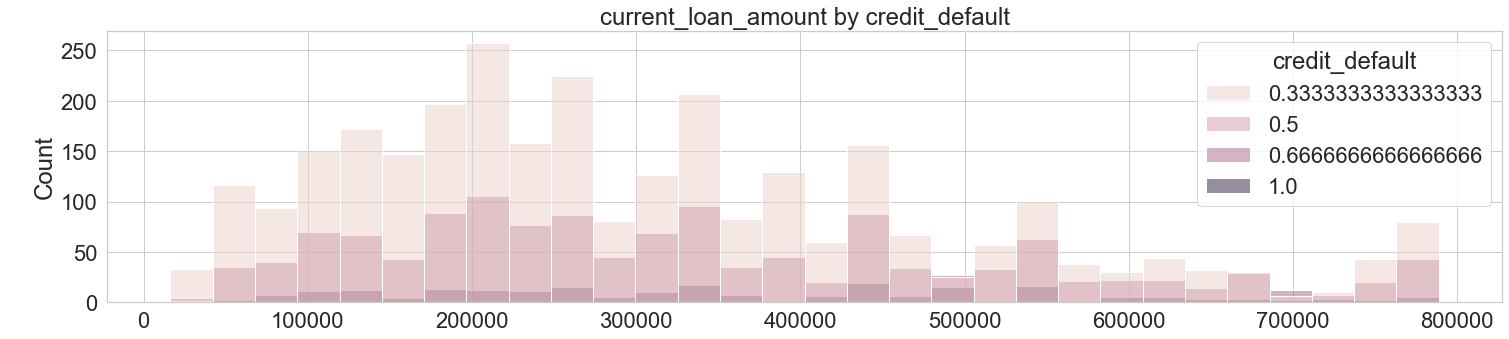

In [ ]:
# Теперь построим график распределения высоковероятного таргета в связи с текущей суммой кредита:
get_histplot(df=df_train[['current_loan_amount', TARGET_NAME]]\
  .sort_values(by='current_loan_amount')\
  .rolling(3, min_periods=1)\
  .mean()\
  .query('credit_default > 0.3'), x='current_loan_amount')

In [ ]:
bins = [0,
        50000,
        450000,
        600000,
        df_train.current_loan_amount.max() - 1,
        df_train.current_loan_amount.max()]

In [ ]:
labels = ["less 50000",
          '50000-450000',
          '450000-800000',
          'more 800000',
          'anormaly'          
          ]
labels

['less 50000', '50000-450000', '450000-800000', 'more 800000', 'anormaly']

In [ ]:
df_train['current_loan_amount_rank'] = pd.cut(df_train.current_loan_amount, bins=bins,labels=labels)
df_test['current_loan_amount_rank'] = pd.cut(df_test.current_loan_amount, bins=bins,labels=labels)

In [ ]:
get_prob_target('current_loan_amount_rank')

,current_loan_amount_rank,credit_default
0,less 50000,0.259542
1,50000-450000,0.304574
2,450000-800000,0.397203
3,more 800000,0.359867
4,anormaly,0.000000


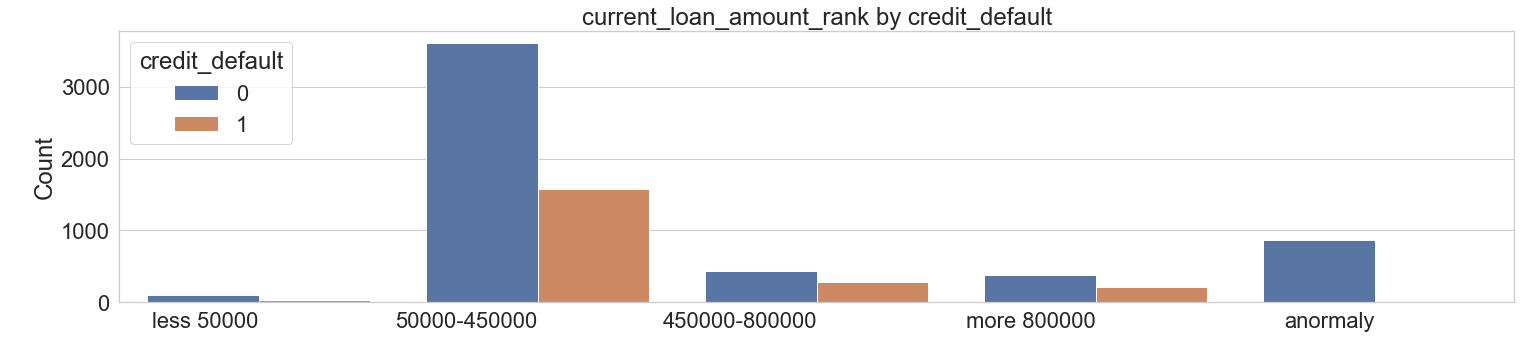

In [ ]:
get_countplot('current_loan_amount_rank')

Ввиду высокой взаимосвязи current_loan_amount(текущая сумма кредита) и annual_income(годовой доход), ввёдем фичу отношения суммы текущего кредита к годовому доходу.

In [ ]:
df_train['proportion_current_loan_annual']=df_train.current_loan_amount / df_train.annual_income
df_test['proportion_current_loan_annual']=df_test.current_loan_amount / df_train.annual_income

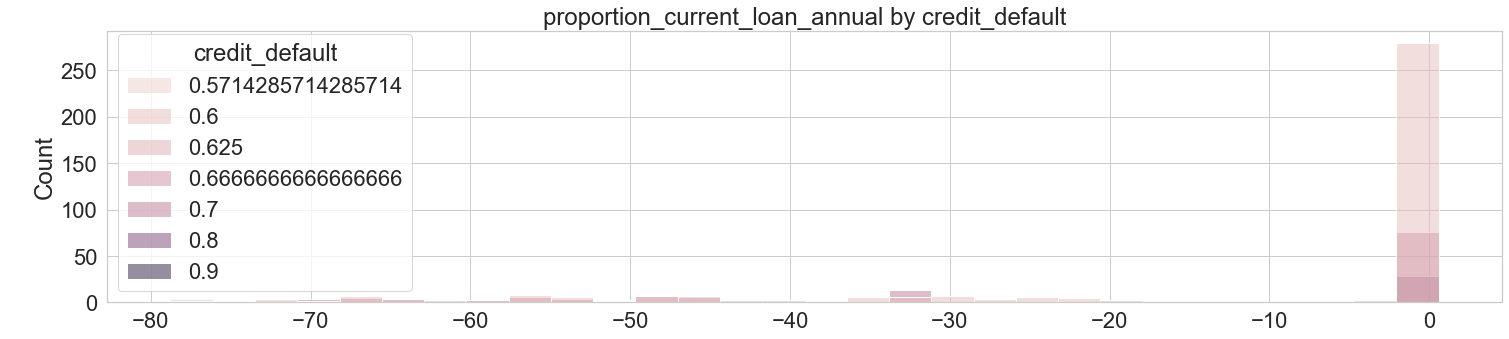

In [ ]:
# Строим график распределения высоковероятного таргета (выше 0,5) в связи с новой фичей
get_histplot(df=df_train[['proportion_current_loan_annual',TARGET_NAME]]\
  .sort_values(by='proportion_current_loan_annual')\
  .rolling(10, min_periods=1)\
  .mean()\
  .query('credit_default > 0.5'), x='proportion_current_loan_annual')

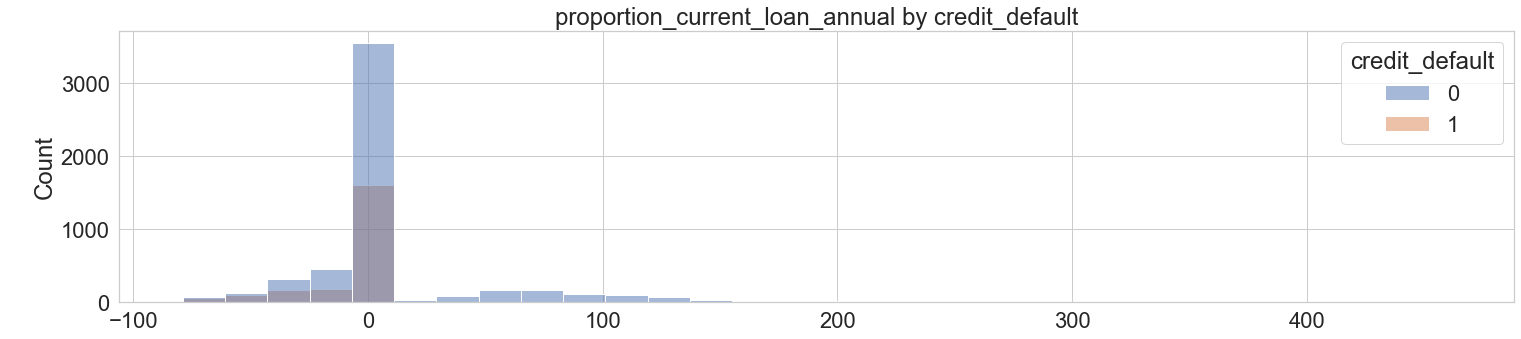

In [ ]:
get_histplot('proportion_current_loan_annual')

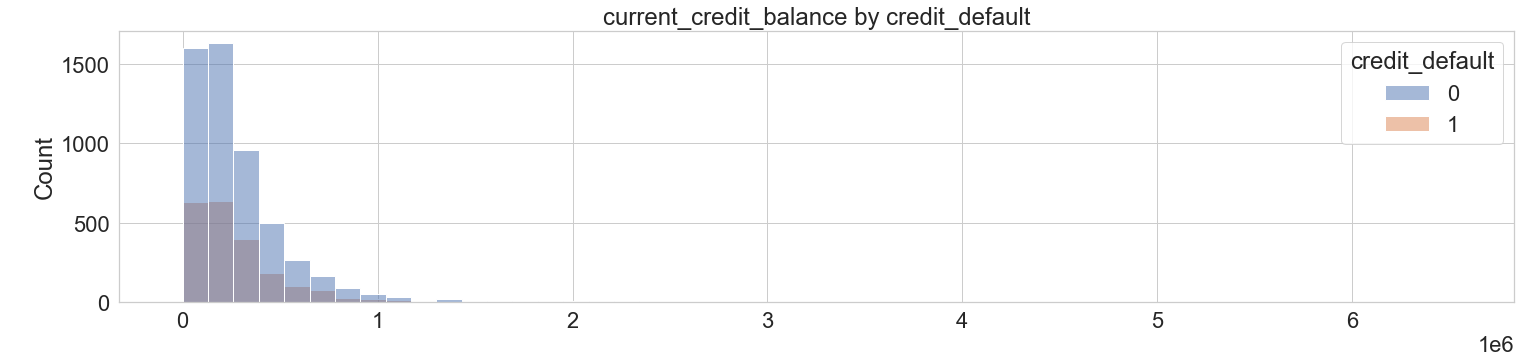

In [ ]:
# Посмотрим на  current_credit_balance (текущий кредитный баланс)

get_histplot('current_credit_balance',bins=50)

array([[<AxesSubplot:title={'center':'current_credit_balance'}>,
        <AxesSubplot:title={'center':'credit_default'}>]], dtype=object)

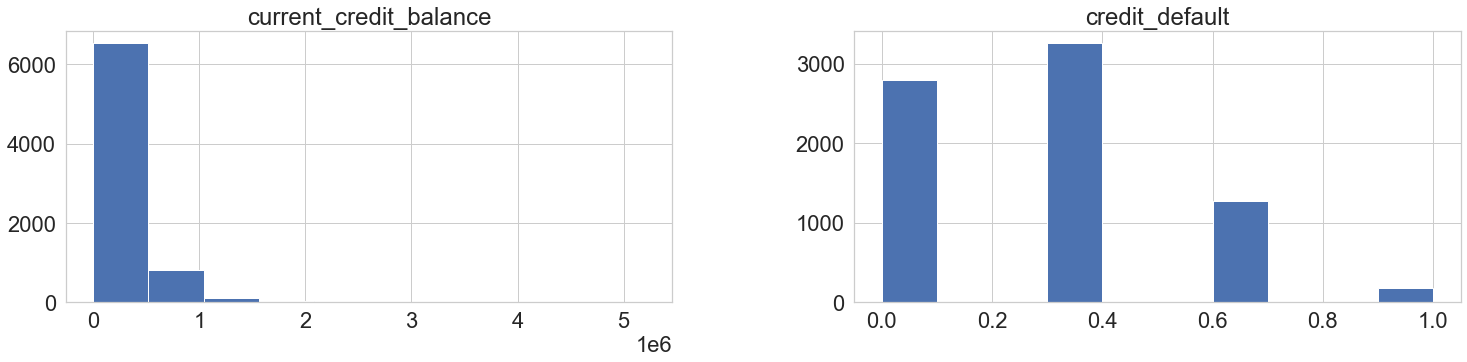

In [ ]:
df_train[['current_credit_balance', TARGET_NAME]]\
  .sort_values(by='current_credit_balance')\
  .rolling(3, min_periods=1)\
  .mean().hist()

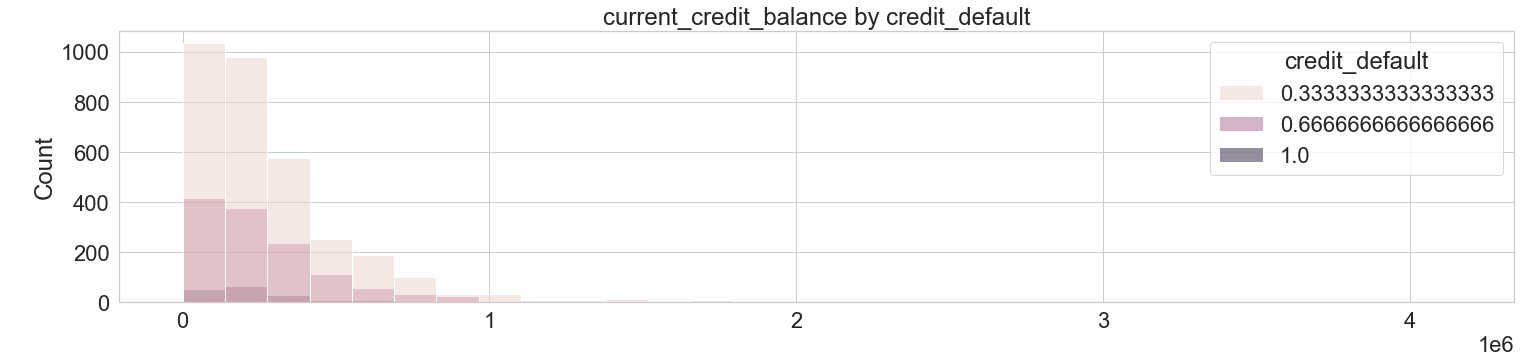

In [ ]:
# Построим график распределения высоковероятного таргета в связи с текущей суммо кредита:
get_histplot(df=df_train[['current_credit_balance', TARGET_NAME]]\
  .sort_values(by='current_credit_balance')\
  .rolling(3, min_periods=1)\
  .mean()\
  .query('credit_default > 0.3'), x='current_credit_balance')

Очевидна прямая зависимость (кореляция) current_credit_balance (текущий кредитный баланс) и credit_default (факт выполнения кредитных обязательств)

In [ ]:
bins = [-1,
        0,
        1000000,
        df_train.current_credit_balance.max()]

In [ ]:
labels = ['0',
         'less 1.000.000',
         'more 1.000.000']

In [ ]:
df_train['current_credit_balance_rank'] = pd.cut(df_train.current_credit_balance, bins=bins,labels=labels)
df_test['current_credit_balance_rank'] = pd.cut(df_test.current_credit_balance, bins=bins,labels=labels)

In [ ]:
get_prob_target('current_credit_balance_rank')

,current_credit_balance_rank,credit_default
0,0,0.169811
1,less 1.000.000,0.284061
2,more 1.000.000,0.223404


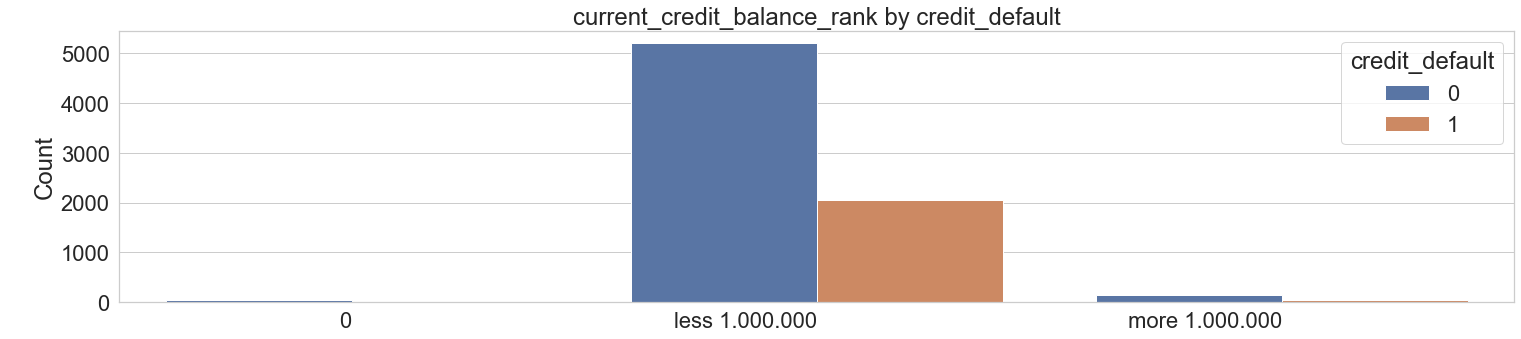

In [ ]:

get_countplot('current_credit_balance_rank')

In [ ]:
# Посмотрим на  credit_score (баллы кредитного рейтинга)

df_train.credit_score.describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: credit_score, dtype: float64

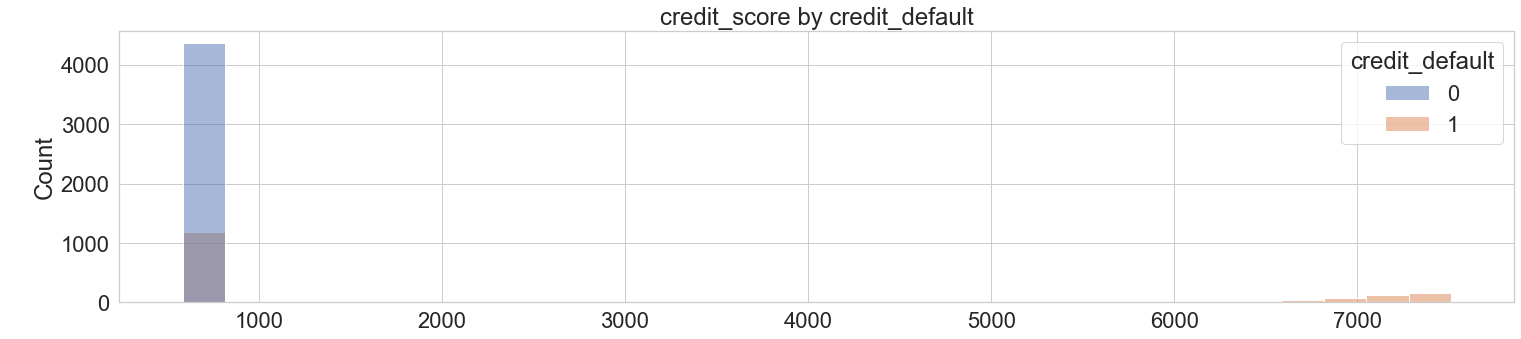

In [ ]:
get_histplot('credit_score')

Видна явная корреляция с тагретом, что хорошо для классификации, но неудобно для заполнения пропущенных данных.

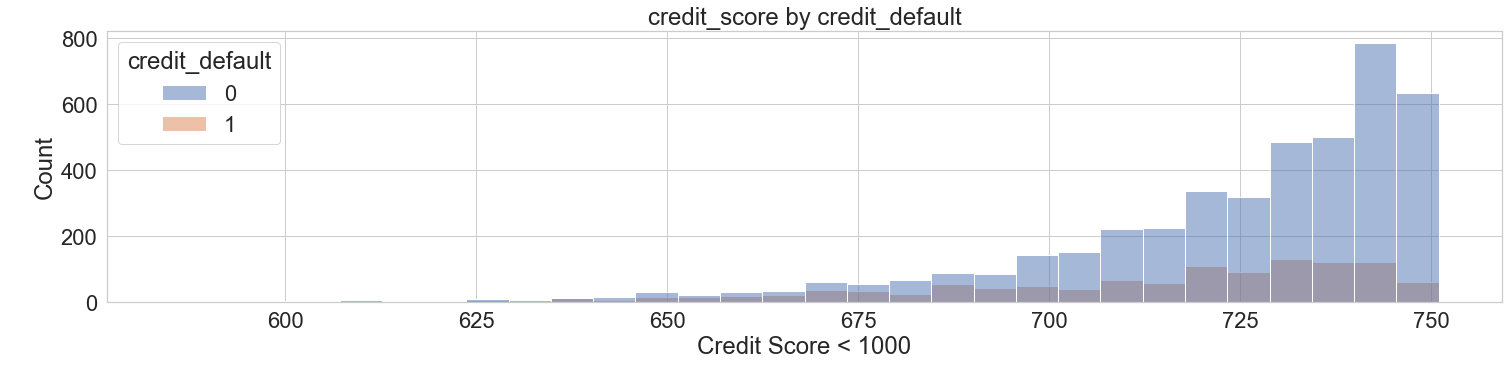

In [ ]:
get_histplot(df=df_train[df_train.credit_score < 1000], x='credit_score', xlabel='Credit Score < 1000')

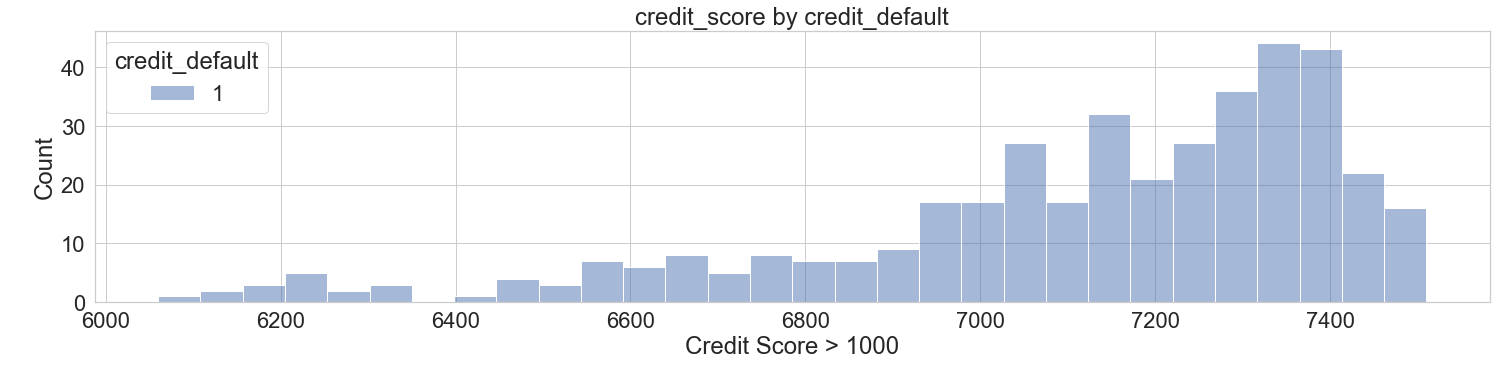

In [ ]:
get_histplot(df=df_train[df_train.credit_score > 1000], x='credit_score', xlabel='Credit Score > 1000')

Показатели выше 1000, которые с одной стороны больше похожи на ошибку, также содержат только один признак (credit_default==1).   
Оставим для модели как признак и зададим единное значение для credit_score > 1000.

In [ ]:
df_train.query('credit_score < 1000').credit_score.max()

751.0

In [ ]:
df_train.loc[df_train.credit_score > 1000, 'credit_score'] = -1
df_test.loc[df_test.credit_score > 1000, 'credit_score'] = -1

In [ ]:
df_train.corr()['credit_score'].sort_values(ascending=False)

credit_score                      1.000000
current_loan_amount               0.131370
proportion_current_loan_annual    0.108755
annual_income_log                 0.050198
annual_income                     0.041801
years_of_credit_history           0.026937
bankruptcies                      0.016170
maximum_open_credit               0.013716
current_credit_balance            0.005055
months_since_last_delinquent     -0.000347
maximum_open_credit_log          -0.009928
monthly_debt                     -0.012219
tax_liens                        -0.013134
number_of_open_accounts          -0.021626
id                               -0.040440
credit_default                   -0.466913
Name: credit_score, dtype: float64

In [ ]:
df_train.loc[df_train.credit_score > 0]

,home_ownership,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,...,current_credit_balance,monthly_debt,credit_score,credit_default,id,annual_income_log,maximum_open_credit_log,current_loan_amount_rank,proportion_current_loan_annual,current_credit_balance_rank
0,Home,482087.0,10+ years,0,11.0,26.3,685960.0,0,32.0,1.0,...,47386.0,7914.0,749.0,0,0,13.085880,13.438575,anormaly,207.431437,less 1.000.000
1,Home,1025487.0,10+ years,0,15.0,15.3,1181730.0,0,32.0,0.0,...,394972.0,18373.0,737.0,1,1,13.840678,13.982490,50000-450000,0.258383,less 1.000.000
2,Home,751412.0,8 years,0,11.0,35.0,1182434.0,0,32.0,0.0,...,308389.0,13651.0,742.0,0,2,13.529709,13.983086,anormaly,133.082781,less 1.000.000
3,Home,805068.0,6 years,0,8.0,22.5,147400.0,0,32.0,1.0,...,95855.0,11338.0,694.0,0,3,13.598682,11.900905,50000-450000,0.150790,less 1.000.000
4,Rent,776264.0,8 years,0,13.0,13.6,385836.0,0,32.0,0.0,...,93309.0,7180.0,719.0,0,4,13.562248,12.863168,50000-450000,0.162110,less 1.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7490,Home,1368000.0,10+ years,0,20.0,26.7,897842.0,0,69.0,0.0,...,517199.0,29868.0,688.0,1,7490,14.128860,13.707749,more 800000,0.499744,less 1.000.000
7491,Home,2833185.0,6 years,0,18.0,21.3,280170.0,0,6.0,0.0,...,108889.0,61150.0,704.0,0,7491,14.856912,12.543152,50000-450000,0.154386,less 1.000.000
7493,Rent,1257610.0,8 years,0,14.0,16.5,821480.0,0,58.0,0.0,...,167428.0,27562.0,676.0,1,7493,14.044724,13.618863,50000-450000,0.356273,less 1.000.000
7495,Rent,402192.0,< 1 year,0,3.0,8.5,107866.0,0,32.0,0.0,...,73492.0,1900.0,697.0,0,7495,12.904685,11.588645,50000-450000,0.321637,less 1.000.000


[Text(0, 0, 'various'),
 Text(1, 0, 'other+medical'),
 Text(2, 0, 'business'),
 Text(3, 0, 'education+moving'),
 Text(4, 0, 'small business')]

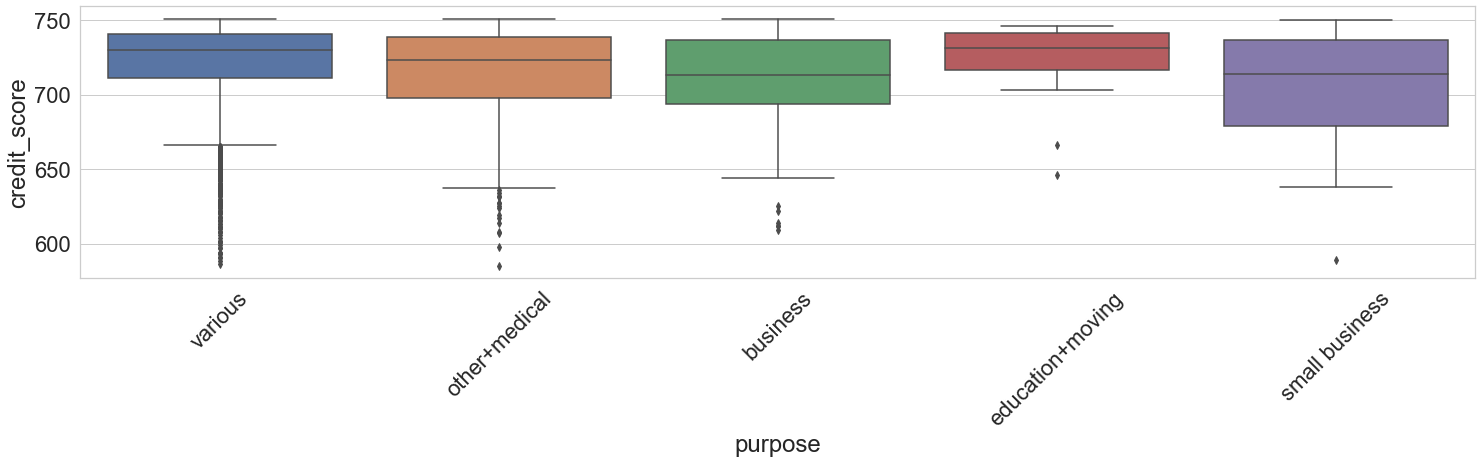

In [ ]:
# Рассмотрим связь: цели кредита и баллы кредитного рейтинга

ax=sns.boxplot(data=df_train.loc[df_train.credit_score > 0], x='purpose', y='credit_score')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

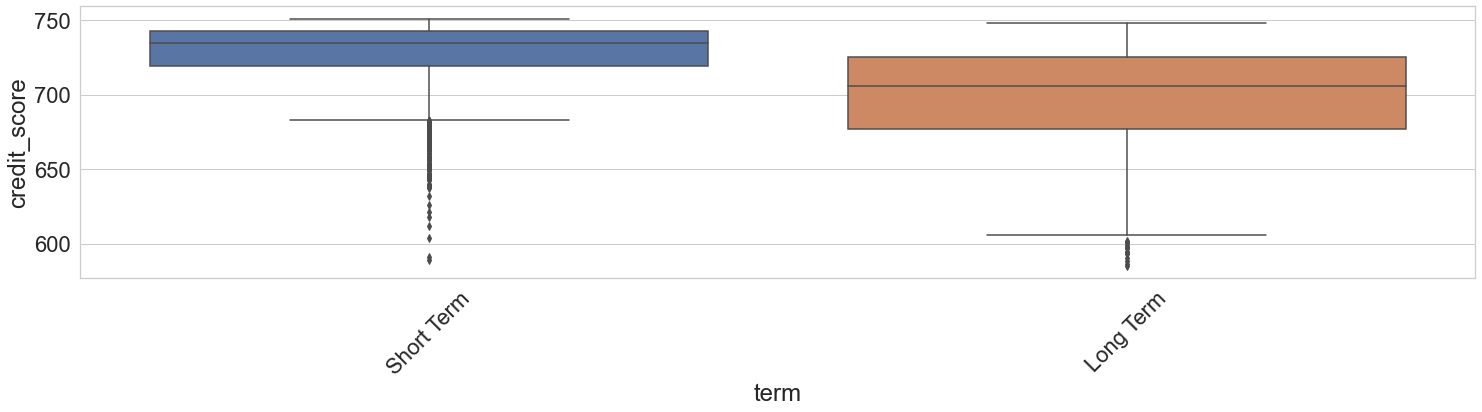

In [ ]:
# Рассмотрим связь: срок кредита и баллы кредитного рейтинга

ax=sns.boxplot(data=df_train.loc[df_train.credit_score > 0], x='term', y='credit_score')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45);

[Text(0, 0, 'Home'), Text(1, 0, 'Rent'), Text(2, 0, 'Have Mortgage')]

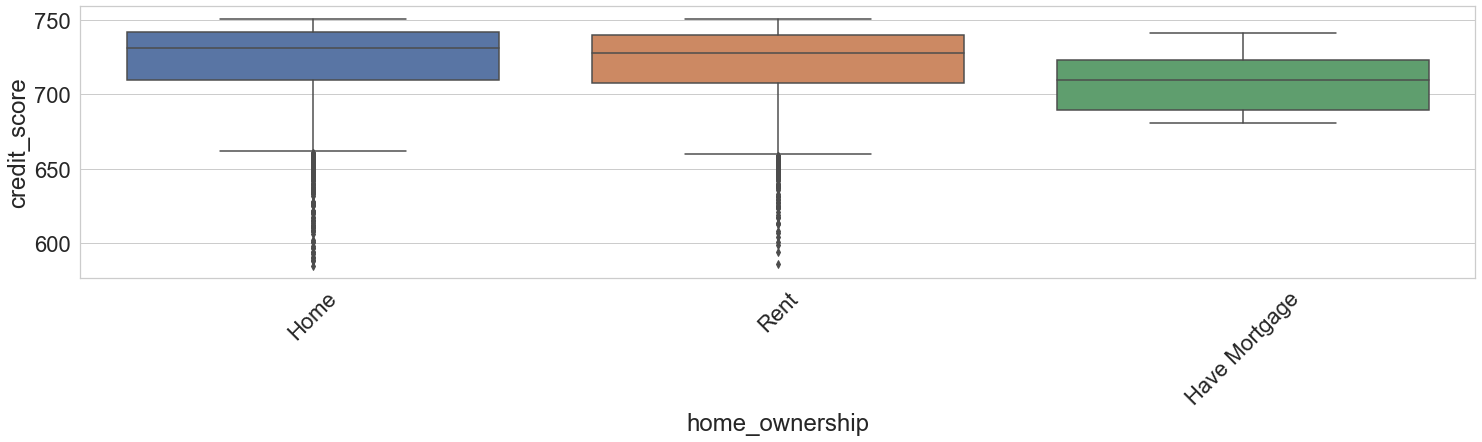

In [ ]:
# Рассмотрим связь: домовладение и баллы кредитного рейтинга

ax=sns.boxplot(data=df_train.loc[df_train.credit_score > 0], x='home_ownership', y='credit_score')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

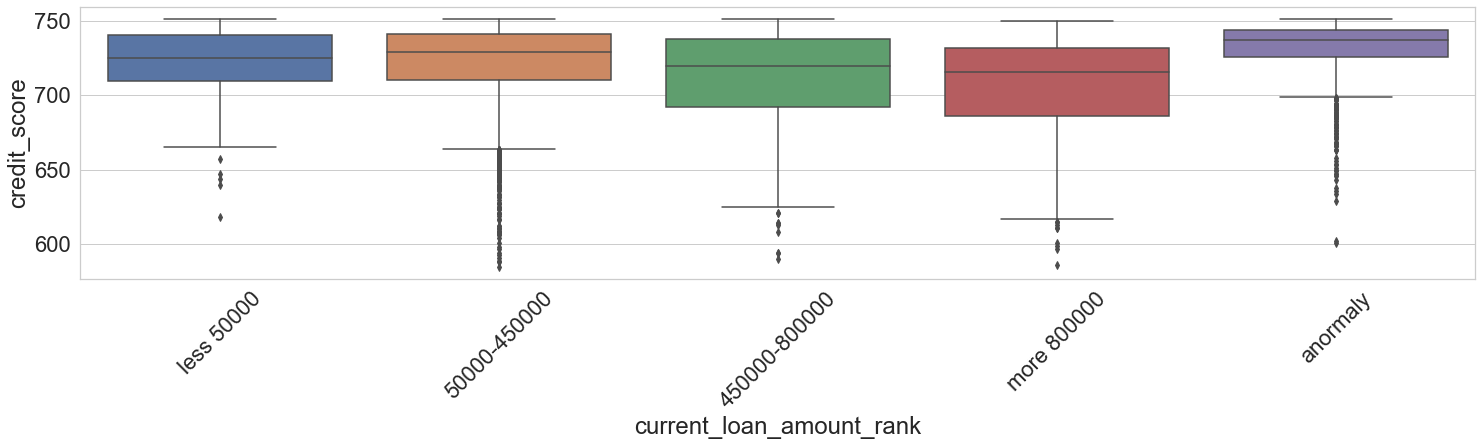

In [ ]:
# Рассмотрим связь: текущая сумма кредита и баллы кредитного рейтинга

ax=sns.boxplot(data=df_train.loc[df_train.credit_score > 0], x='current_loan_amount_rank', y='credit_score')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45);

In [ ]:
df_train.credit_score.isna().sum()

1557

In [ ]:
df_train.loc[df_train.credit_score.isna(),'credit_score'].isna().sum()

1557

In [ ]:
# Заполним медианой по наиболее скоррелированной переменой и медианою:

credit_score_mean_grby=df_train.groupby(['current_loan_amount','term'])['credit_score'].transform('median')
credit_score_mean_grby_test=df_test.groupby(['current_loan_amount','term'])['credit_score'].transform('median')

In [ ]:
df_train.credit_score.fillna(credit_score_mean_grby, inplace=True)
df_test.credit_score.fillna(credit_score_mean_grby_test, inplace=True)

In [ ]:
df_train.credit_score.isna().sum()

1223

In [ ]:
df_test.credit_score.isna().sum()

471

In [ ]:
# Остальные данные, которые не попали ни в term (срок кредита), ни в purpose (цель кредита), заменим на общую медиану:

df_train.credit_score.fillna(df_train.credit_score.median(), inplace=True)
df_test.credit_score.fillna(df_test.credit_score.median(), inplace=True)

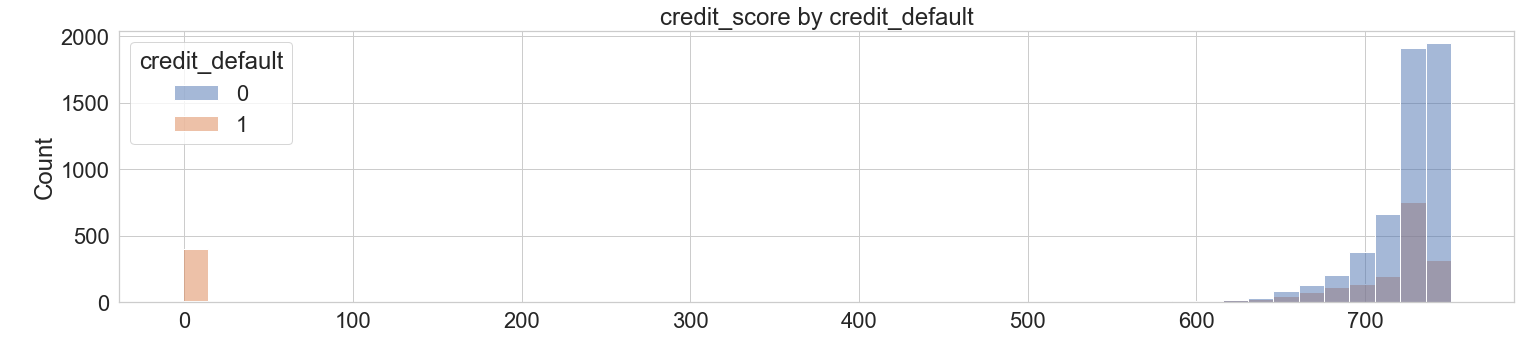

In [ ]:
# Разделим переменную на ранги:

get_histplot('credit_score',bins=50)

In [ ]:
df_train[df_train.credit_score < 1000].credit_score.max()

751.0

In [ ]:
bins = [-2,
        0,
        700,        
        740,
        750,
        df_train.credit_score.max()
       ]

In [ ]:
labels = ['-1',         
          'less 700',
         '700-740',
         '740-750',
         'more 750'
         ]

In [ ]:
df_train['credit_score_rank'] = pd.cut(df_train.credit_score,bins=bins,labels=labels)
df_test['credit_score_rank'] = pd.cut(df_test.credit_score,bins=bins,labels=labels)

In [ ]:
get_prob_target('credit_score_rank')

,credit_score_rank,credit_default
0,-1,0.980535
1,less 700,0.354454
2,700-740,0.253685
3,740-750,0.126626
4,more 750,0.049180


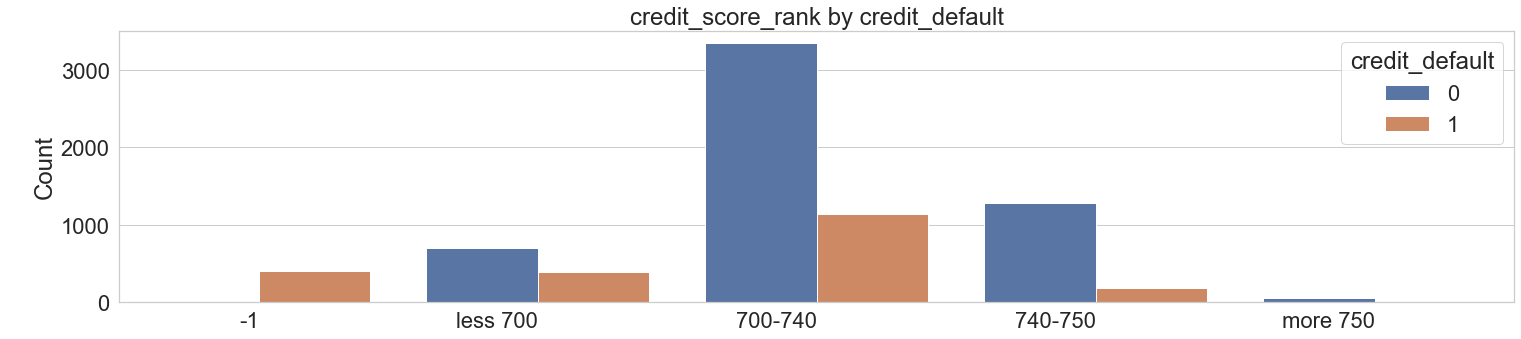

In [ ]:
get_countplot('credit_score_rank')

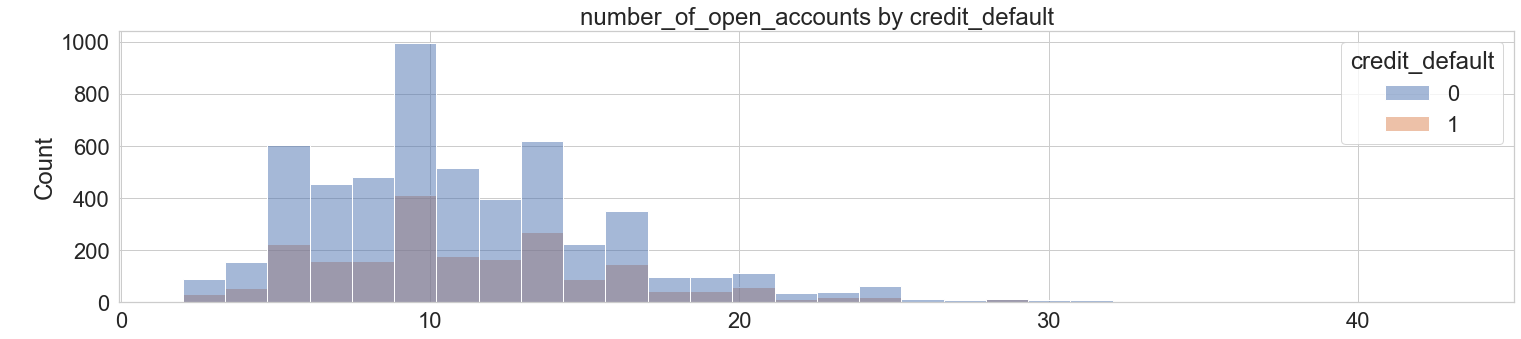

In [ ]:
# Посмотрим на  number_of_open_accounts (количество открытых счетов)

get_histplot('number_of_open_accounts',bins=30)

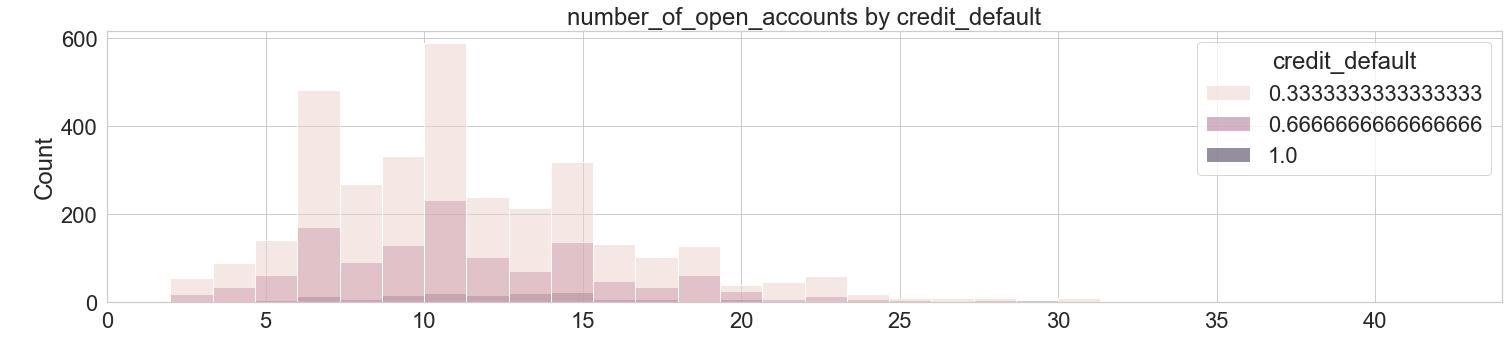

In [ ]:
#построим график распределения высоковероятного таргета в связи с текущей суммо кредита
get_histplot(df=df_train[['number_of_open_accounts',TARGET_NAME]]\
  .sort_values(by='number_of_open_accounts')\
  .rolling(3, min_periods=1)\
  .mean()\
  .query('credit_default > 0.28'), x='number_of_open_accounts')

Корреляция высокая, но этот показатель (количество открытых счетов) может вводить в заблуждение

In [ ]:
df_train.number_of_open_accounts.apply(int)
df_test.number_of_open_accounts.apply(int)

0        9
1        6
2       10
3       16
4       11
        ..
2495    14
2496    15
2497    48
2498    14
2499    12
Name: number_of_open_accounts, Length: 2500, dtype: int64

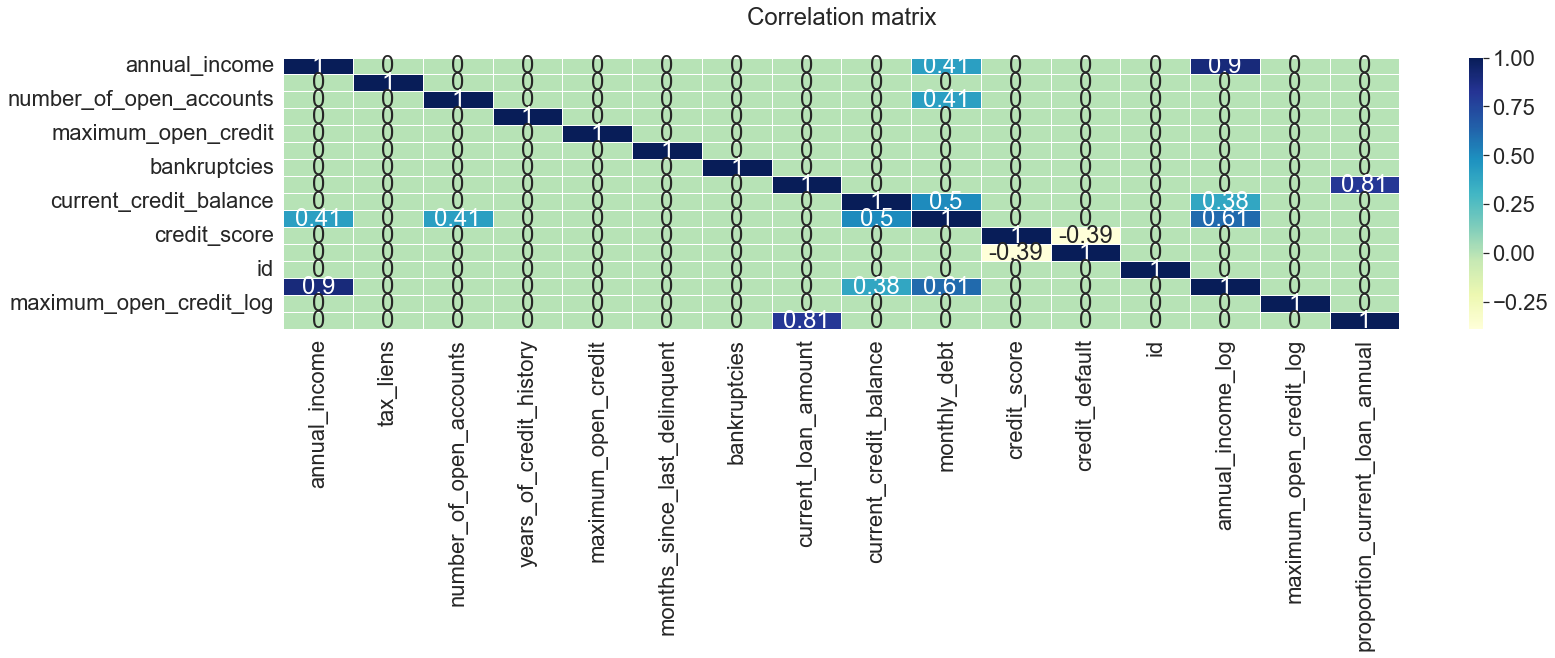

In [ ]:
# Матрица корреляции получившхся некатегориальных признаков:

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='YlGnBu')

plt.title('Correlation matrix\n')
plt.show()

**Подготовим данные для CatBoost**

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   home_ownership                  7500 non-null   object  
 1   annual_income                   7500 non-null   float64 
 2   years_in_current_job            7500 non-null   object  
 3   tax_liens                       7500 non-null   int64   
 4   number_of_open_accounts         7500 non-null   float64 
 5   years_of_credit_history         7500 non-null   float64 
 6   maximum_open_credit             7500 non-null   float64 
 7   number_of_credit_problems       7500 non-null   category
 8   months_since_last_delinquent    7500 non-null   float64 
 9   bankruptcies                    7500 non-null   float64 
 10  purpose                         7500 non-null   object  
 11  term                            7500 non-null   object  
 12  current_loan_amount 

In [ ]:
df_train.bankruptcies = df_train.bankruptcies.apply(int)
df_test.bankruptcies = df_train.bankruptcies.apply(int)

In [ ]:
CAT_FEATURES = ['home_ownership',
                'years_in_current_job',
                'tax_liens',
                'bankruptcies',
                'purpose',
                'term',
                'current_loan_amount_rank',
                'credit_score_rank',
                'number_of_credit_problems',
                'current_credit_balance_rank']

In [ ]:
df_train[CAT_FEATURES]

,home_ownership,years_in_current_job,tax_liens,bankruptcies,purpose,term,current_loan_amount_rank,credit_score_rank,number_of_credit_problems,current_credit_balance_rank
0,Home,10+ years,0,1,various,Short Term,anormaly,740-750,0,less 1.000.000
1,Home,10+ years,0,0,various,Long Term,50000-450000,700-740,0,less 1.000.000
2,Home,8 years,0,0,various,Short Term,anormaly,740-750,0,less 1.000.000
3,Home,6 years,0,1,various,Short Term,50000-450000,less 700,0,less 1.000.000
4,Rent,8 years,0,0,various,Short Term,50000-450000,700-740,0,less 1.000.000
...,...,...,...,...,...,...,...,...,...,...
7495,Rent,< 1 year,0,0,other+medical,Short Term,50000-450000,less 700,0,less 1.000.000
7496,Home,1 year,0,0,various,Long Term,50000-450000,-1,0,less 1.000.000
7497,Rent,6 years,0,0,various,Short Term,anormaly,740-750,0,less 1.000.000
7498,Home,10+ years,0,0,various,Short Term,more 800000,700-740,0,less 1.000.000


**Строим модель**

In [ ]:
y = df_train[TARGET_NAME]

In [ ]:
X = df_train.drop(columns=['id',TARGET_NAME])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.isna().sum()

home_ownership                       0
annual_income                        0
years_in_current_job                 0
tax_liens                            0
number_of_open_accounts              0
years_of_credit_history              0
maximum_open_credit                  0
number_of_credit_problems            0
months_since_last_delinquent         0
bankruptcies                         0
purpose                              0
term                                 0
current_loan_amount                  0
current_credit_balance               0
monthly_debt                         0
credit_score                         0
annual_income_log                 1232
maximum_open_credit_log              0
current_loan_amount_rank             0
proportion_current_loan_annual       0
current_credit_balance_rank          0
credit_score_rank                    0
dtype: int64

In [ ]:
pool = catb.Pool(X,y, cat_features=CAT_FEATURES)

In [ ]:
train_pool = catboost_pool = catb.Pool(X_train, y_train, cat_features=CAT_FEATURES)                                     
test_pool = catb.Pool(X_test, cat_features=CAT_FEATURES) 

In [ ]:
model = catb.CatBoostClassifier(
            loss_function='Logloss',
            eval_metric='F1',
            random_seed=42,
            logging_level='Silent',
            auto_class_weights='Balanced',
            n_estimators=500,
            learning_rate=0.06,
            l2_leaf_reg=2,
            depth=3,
            bagging_temperature=0.1,
            random_strength=.15)

In [ ]:
model.fit(
        X_train, y_train,
        cat_features=CAT_FEATURES,
        eval_set=(X_test, y_test),
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
preds_class = model.predict(test_pool)
print(f'f1-score = {f1_score(y_pred=preds_class, y_true=y_test):.4f} \n\
Взвешенный f1-score = {f1_score(y_pred=preds_class, y_true=y_test, average="weighted"):.4f} \n\
f1-macro= {f1_score(y_pred=preds_class, y_true=y_test, average="macro"):.4f}')

f1-score = 0.5712 
Взвешенный f1-score = 0.7166 
f1-macro= 0.6741


In [ ]:
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
12,current_loan_amount,36.362814
15,credit_score,21.621893
18,current_loan_amount_rank,10.631230
19,proportion_current_loan_annual,9.139774
1,annual_income,2.427768
6,maximum_open_credit,2.302457
11,term,2.214182
13,current_credit_balance,2.203580
14,monthly_debt,2.063493
16,annual_income_log,1.797778


Text(0, 0.5, 'Features\n')

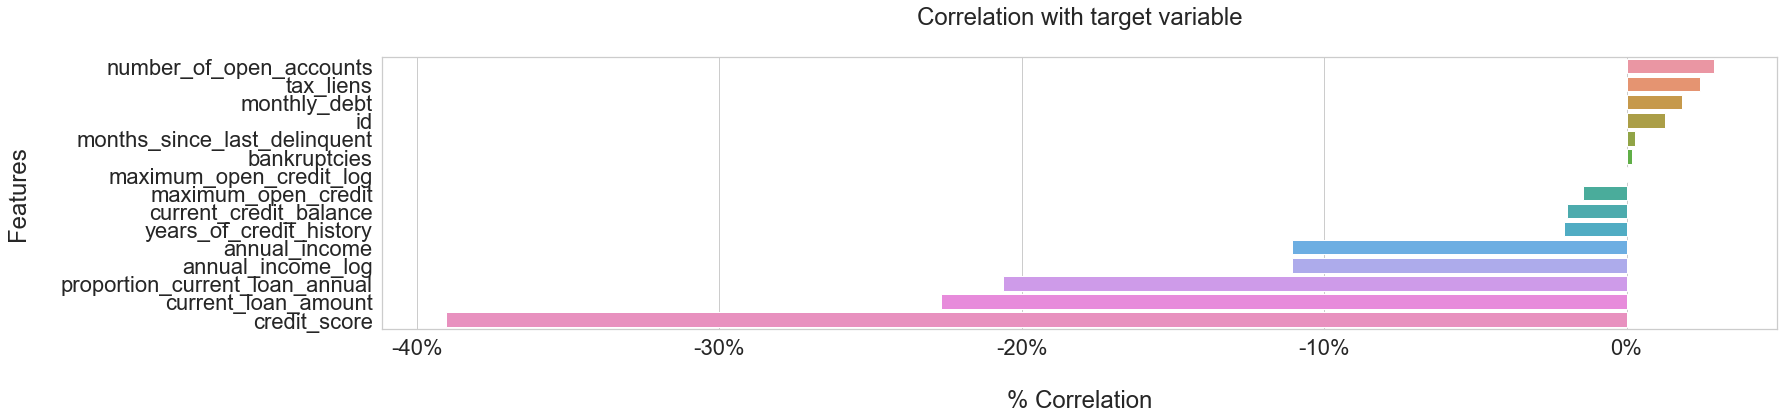

In [ ]:
# Посмотрим на корреляцию итоговых данных:

corr_with_target = df_train.corr()[TARGET_NAME].sort_values(ascending=False)[1:]

ax=sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

ax.set_title('Correlation with target variable\n')
ax.set_xlabel('\n% Correlation')
ax.set_xticklabels([f'{x:.0%}' for x in ax.get_xticks()])
ax.set_ylabel('Features\n')

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      4328
           1       0.54      0.72      0.62      1672

    accuracy                           0.75      6000
   macro avg       0.71      0.74      0.72      6000
weighted avg       0.78      0.75      0.76      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.72      0.78      1059
           1       0.50      0.66      0.57       441

    accuracy                           0.71      1500
   macro avg       0.67      0.69      0.67      1500
weighted avg       0.74      0.71      0.72      1500

CONFUSION MATRIX

col_0             0    1
credit_default          
0               767  292
1               148  293


In [ ]:
y_test_pred_probs = model.predict_proba(X_test)

In [ ]:
pred_test = np.where(y_test_pred_probs[:, 1] >= 0.5, 1, 0)

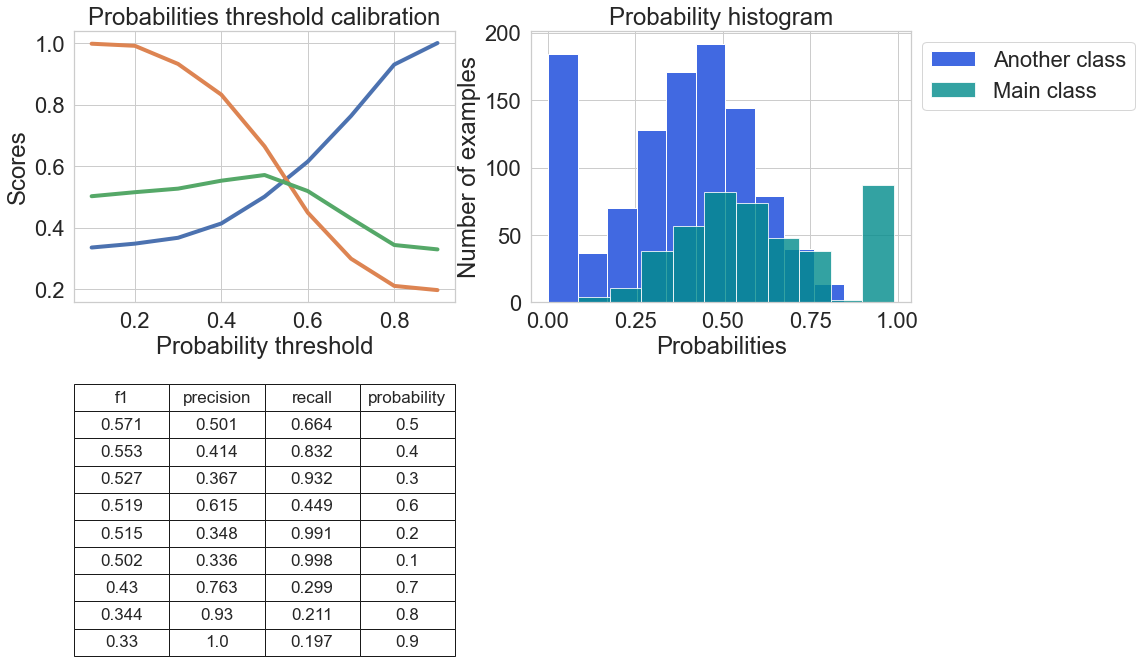

In [ ]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [ ]:
print(f'f1-score = {f1_score(y_pred=pred_test, y_true=y_test):.4f} \n\
Взвешенный f1-score = {f1_score(y_pred=pred_test, y_true=y_test, average="weighted"):.4f} \n\
f1-macro= {f1_score(y_pred=pred_test, y_true=y_test, average="macro"):.4f}')

f1-score = 0.5712 
Взвешенный f1-score = 0.7166 
f1-macro= 0.6741


In [ ]:
get_classification_report(y_train, y_train_pred, y_test, pred_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      4328
           1       0.54      0.72      0.62      1672

    accuracy                           0.75      6000
   macro avg       0.71      0.74      0.72      6000
weighted avg       0.78      0.75      0.76      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.72      0.78      1059
           1       0.50      0.66      0.57       441

    accuracy                           0.71      1500
   macro avg       0.67      0.69      0.67      1500
weighted avg       0.74      0.71      0.72      1500

CONFUSION MATRIX

col_0             0    1
credit_default          
0               767  292
1               148  293


**Прогнозирование на тестовой выборке**

In [ ]:
df_test.head()

,home_ownership,annual_income,years_in_current_job,tax_liens,number_of_open_accounts,years_of_credit_history,maximum_open_credit,number_of_credit_problems,months_since_last_delinquent,bankruptcies,...,current_loan_amount,current_credit_balance,monthly_debt,credit_score,annual_income_log,maximum_open_credit_log,current_loan_amount_rank,proportion_current_loan_annual,current_credit_balance_rank,credit_score_rank
0,Rent,NaN,4 years,0,9.0,12.5,220968.0,0,70.0,1,...,162470.0,105906.0,6813.0,725.0,NaN,12.305773,50000-450000,0.337014,less 1.000.000,700-740
1,Rent,231838.0,1 year,0,6.0,32.7,55946.0,0,8.0,0,...,78298.0,46037.0,2318.0,699.0,12.353794,10.932142,50000-450000,0.076352,less 1.000.000,less 700
2,Home,1152540.0,3 years,0,10.0,13.7,204600.0,0,32.0,0,...,200178.0,146490.0,18729.0,-1.0,13.957479,12.228812,50000-450000,0.266402,less 1.000.000,-1
3,Home,1220313.0,10+ years,0,16.0,17.0,456302.0,0,70.0,1,...,217382.0,213199.0,27559.0,739.0,14.014618,13.030910,50000-450000,0.270017,less 1.000.000,700-740
4,Home,2340952.0,6 years,0,11.0,23.6,1207272.0,0,32.0,0,...,777634.0,425391.0,42605.0,706.0,14.666068,14.003874,more 800000,1.001765,less 1.000.000,700-740


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   home_ownership                  2500 non-null   object  
 1   annual_income                   1987 non-null   float64 
 2   years_in_current_job            2500 non-null   object  
 3   tax_liens                       2500 non-null   int64   
 4   number_of_open_accounts         2500 non-null   float64 
 5   years_of_credit_history         2500 non-null   float64 
 6   maximum_open_credit             2500 non-null   float64 
 7   number_of_credit_problems       2500 non-null   category
 8   months_since_last_delinquent    2500 non-null   float64 
 9   bankruptcies                    2500 non-null   int64   
 10  purpose                         2500 non-null   object  
 11  term                            2500 non-null   object  
 12  current_loan_amount 

In [ ]:
df_test.isna().sum()

home_ownership                      0
annual_income                     513
years_in_current_job                0
tax_liens                           0
number_of_open_accounts             0
years_of_credit_history             0
maximum_open_credit                 0
number_of_credit_problems           0
months_since_last_delinquent        0
bankruptcies                        0
purpose                             0
term                                0
current_loan_amount                 0
current_credit_balance              0
monthly_debt                        0
credit_score                        0
annual_income_log                 513
maximum_open_credit_log             0
current_loan_amount_rank            0
proportion_current_loan_annual      0
current_credit_balance_rank         0
credit_score_rank                   0
dtype: int64

In [ ]:
df_test.number_of_open_accounts = df_test.number_of_open_accounts.apply(str)
df_test.number_of_open_accounts 

0        9.0
1        6.0
2       10.0
3       16.0
4       11.0
        ... 
2495    14.0
2496    15.0
2497    48.0
2498    14.0
2499    12.0
Name: number_of_open_accounts, Length: 2500, dtype: object

In [ ]:
CAT_FEATURES

['home_ownership',
 'years_in_current_job',
 'tax_liens',
 'bankruptcies',
 'purpose',
 'term',
 'current_loan_amount_rank',
 'credit_score_rank',
 'number_of_credit_problems',
 'current_credit_balance_rank']

In [ ]:
course_test_pool = catb.Pool(df_test, cat_features=CAT_FEATURES)

In [ ]:
target_pred_prob = model.predict_proba(course_test_pool)
target_pred = np.where(target_pred_prob[:, 1] >= 0.5, 1, 0)
target_pred

array([1, 1, 1, ..., 0, 0, 1])

In [ ]:
target_pred = pd.DataFrame(target_pred)
submission_target = target_pred.rename(columns={0:'Solution'})
submission_target

,Solution
0,1
1,1
2,1
3,0
4,0
...,...
2495,0
2496,1
2497,0
2498,0


In [ ]:
submission_target.to_csv('Sadovenko_predictions.csv')